# Machine Learning for Business SS 2019

# Motivation
Since the value of many products. e.g. cars, are not directly observable, negotiations between a seller and a potential buyer can be arduous.
The actors of a negotiation are challanged by different biases and uncertainties.
On the one hand the sellers are often affected by the endowment effect - they "demand much more to give up an object than they would be willing to pay to acquire it" [(Kahneman, Daniel et al. (1991))](#Kahneman,-Daniel-et-al.-(1991)).
On the other hand the potential buyer faces uncertainty prior the purchase which leads to a search for more information [(Bauer, R. A. et al. (1967))](#Bauer,-R.-A.-et-al.-(1967)).
Together these problems can cause too high prices and unnecessary search costs.
In our case study the sellers and the buyers of the digital platform <a href="https://craigslist.org">craigslist</a> probably face the two mentioned difficulties during the transactions processes of (used) cars.
In this notebook we present a potential solution, that recommends the seller and the buyer based on the attributes and a picture of the car a suitable price.

---

# Relevance for Business
We consider this problem to be relevant for the following reasons:
* Enable inexperienced sellers or young companies to assess the value of (used) cars.
* Assistance for the possible further value exploitation of the advertisement by better pictures and more detailed data
* Presentation of a price evaluation for customers, if the price for the offer is appropriate.
* Value assessments for all institutions such as insurance companies or state garnishments (algorithms could later be further trained with pictures and tabular data on accident cars, so that, for example, a residual value of the car or the damage incurred can be estimated).

# Imports, Folder Structure, Helper Methods

In [1]:
%config IPCompleter.greedy=True

# Import packages
import numpy as np
import pandas as pd
import math

# pip install pandas_profiling
import pandas_profiling

import pickle

import requests
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(16,9)})

# pip install beautifulsoup4
from bs4 import BeautifulSoup

from urllib.request import urlopen
from urllib.request import urlretrieve
import urllib

# pip install tqdm
from tqdm import tqdm_notebook as tqdm

import datetime
import ast
import os

from sympy import symbols, solve

from IPython.display import Markdown, display, Image

In [2]:
 # Create empty folder 'Data' to save there the datasets
!mkdir ..\Data

# Create a folder for all car images that will be downloaded from the craigslist server to process them.
!mkdir ..\Data\car_images

# Create a folder for reports and a folder for the saved models
!mkdir ..\Reports
!mkdir ..\Models

!mkdir ..\Models\neural_networks

!mkdir ..\Models\neural_networks\simple_nn_ordinal
!mkdir ..\Models\neural_networks\simple_nn_onehot
!mkdir ..\Models\neural_networks\simple_nn_binary

Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Data" existiert bereits.
Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Data\car_images" existiert bereits.
Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Reports" existiert bereits.
Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Models" existiert bereits.
Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Models\neural_networks" existiert bereits.
Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Models\neural_networks\simple_nn_ordinal" existiert bereits.
Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Models\neural_networks\simple_nn_onehot" existiert bereits.
Ein Unterverzeichnis oder eine Datei mit dem Namen "..\Models\neural_networks\simple_nn_binary" existiert bereits.


Within this chapter auxiliary methods are provided, which are needed for later operations.

In [2]:
def set_car_id(dataframe):
    """
    Set's an index value to every item row.

    Parameters
    ----------
    dataframe : pandas.dataframe
        Whole dataset of craigslist inserates.
    """
    dataframe['car_id'] = range(1, len(dataframe) + 1)

In [4]:
def crawl_all_car_image_urls(dataframe):
    """
    Crawl all car image urls (e.g. http).

    Parameters
    ----------
    dataframe : pandas.dataframe
        Whole dataset with the needed car links of craigslist inserates.
    """
    counter = 0
    counter_1 = 0
    counter_2 = 0
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        
        if row["image_url_list"] == 'None':
            if counter_2 == 50:
                counter_2 = 0
                dataframe.to_csv('../Data/craigslistVehicles_with_all_images.csv')
            
            if counter == 100:
                counter = 0
                time.sleep(15)

            if counter_1 == 500:
                counter_1 = 0
                time.sleep(100)


            #print("Get: "+row["url"])
            try:
                website_url = urlopen(row["url"])
                soup = BeautifulSoup(website_url.read())
                img_tags = soup.findAll("img")

                urls = [img['src'] for img in img_tags]
                reworked_urls = []

                for url in urls:
                    reworked_urls.append(url.replace('50x50c', '600x450'))        

                del urls, img_tags, soup, website_url

                dataframe.at[index, 'image_url_list'] = reworked_urls
            except urllib.error.HTTPError:
                #print("Not reachable: "+row["url"])
                dataframe.at[index, 'image_url_list'] = []
            except:
                new_dataframe = pd.read_csv("../Data/craigslistVehicles_with_all_images.csv")
                time.sleep(100)
                crawl_all_car_image_urls(new_dataframe)
                
            counter = counter +1
            counter_1 = counter_1 + 1
            counter_2 = counter_2 + 1
    del counter, counter_1, counter_2, new_dataframe, reworked_urls, urls, dataframe, soup, website_url, img_tags

In [5]:
def crawl_car_images(dataframe):
    """
    Crawl car images from an URL (e.g. http).

    Parameters
    ----------
    dataframe : pandas.dataframe
        Whole dataset with the needed car image links of craigslist inserates.
    """
    urls_not_found = []
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        car_id = row["car_id"]
        #if row["image_url_list"] != 'None' and ast.literal_eval(row["image_url_list"]) == []:
        if row["image_url"] and not os.path.isfile('../Data/car_images/{}.jpg'.format(car_id)):
            try:
                urllib.request.urlretrieve(row["image_url"], "../Data/car_images/{}.jpg".format(car_id))
            except urllib.error.HTTPError as exc:
                print(str(exc) + " With URL: " + row["image_url"])
                urls_not_found.append(row["image_url"])
            except Exception as exc:
                print(exc)
                crawl_car_images(dataframe)
    return urls_not_found
 
# elif row["image_url_list"] != 'None' and ast.literal_eval(row["image_url_list"]) != []:
#     image_url_list = check_for_duplicates(
#                                 ast.literal_eval(
#                                     row['image_url_list']
#                                 )
#                             )
#     counter = 0
#     for image_url in image_url_list:
#         try:
#             urllib.request.urlretrieve(image_url, "../Data/car_images/car_{}_{}.jpg".format(car_id, counter))
#             counter = counter + 1
#         except:
#             print("Image not found")

In [6]:
def check_for_duplicates(x):
    """
    Check list for duplicates and remove them.

    Parameters
    ----------
    x : python.list
        Contains a list of urls as strings.
    """
    return list(dict.fromkeys(x))

In [7]:
def delete_cars_with_invalid_url(dataframe, url_list):
    """
    Remove out of the dataframe every car, which has an invalid url.

    Parameters
    ----------
    dataframe : pandas.dataframe
        Whole dataset with the needed car image links of craigslist inserates.
        
    url_list : python.list
        Contains a list of urls as strings.
    """
    for index, row in dataframe.iterrows():
        if row["image_url"] in url_list:
            dataframe = dataframe.drop(index)
    return dataframe

In [3]:
def createPriceCategories(df, stepsize=5000):
    """
    Creates a new coloumn with the according price category

    Parameters
    ----------
    df : pandas.dataframe
        Whole dataset with the needed price values.
        
    stepsize : python.int
        Sets the stepsize for the categories. Default 5000
        Example:
            Category 0: 0 <= price < 5000
            Category 1: 5000 <= price < 10000
    """
    temp_list=[]
    maxPrice = df.price.max()
    categories = int(maxPrice/stepsize) + 1
    for i in df.price.values:
        for j in range(1,categories+1):
            if(i >= (j-1)*stepsize and i < j*stepsize):
                temp_list.append(j-1)
                
    print(len(temp_list))
    df.insert(1,"priceCategory" ,temp_list, True)
    return df      

In [4]:
def save_pickle_time(out, name):
    with open (f'../Reports/{name}_{str(datetime.datetime.now().date())}--{str(datetime.datetime.now().time().replace(microsecond=0).strftime("%H-%M-%S"))}.pkl', 'wb') as fp:
        pickle.dump(out, fp)        
        
def read_pickle(name):
    with open(f'../Reports/{name}.pkl', 'rb') as f:
        return pickle.load(f)

In [10]:
def plot_nn_history(model_history, title):
    """
    Creates a plot to show the difference on the 500 first actual and forecast values.

    Parameters
    ----------
    model_history : tensorflow.model.History
        Contains the trainings history of a model.
    titel : string
        Contains the title of the plot.
    """
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(10,5))

    plt.plot(epochs, loss, 'bo', label='Training Loss', markersize=6, color='blue')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss', markersize=6, color='red')
    plt.title(title, fontsize=18)
    plt.legend()
    
    plt.savefig('./img/{}.png'.format(title))
    plt.show

In [11]:
def load_best_nn(model_name, manual=False):
    """
    Loads the best neural network model from file.

    Parameters
    ----------
    model_name : string
        Contains name of a neural network model.
    manual : boolean
        Contains a True if the hyperparamter of the model was set manual.
        Default is False.

    Returns
    -------
    tensorflow.keras.models.Model
        Contains the best model for the given model name.
    """
    import tensorflow
    
    directory = "../Models/neural_networks/{}/".format(model_name)
    best_model = None
    best_model_name = None

    for filename in os.listdir(directory):       
        if manual:
            if filename.endswith(".hdf5") and '-manual-' in filename:
                number = filename.replace('{}-manual-'.format(model_name), '')
                number = number.replace('.hdf5', '')
                number = float(number)

                if best_model == None:
                    best_model = number
                    best_model_name = filename
                elif (best_model > number and number > 0) or best_model < 0:
                    best_model = number
                    best_model_name = filename
        else:
            if filename.endswith(".hdf5") and '-manual-' not in filename:
                number = filename.replace('{}-'.format(model_name), '')
                number = number.replace('.hdf5', '')
                number = float(number)

                if best_model == None:
                    best_model = number
                    best_model_name = filename
                elif (best_model > number and number > 0) or best_model < 0:
                    best_model = number
                    best_model_name = filename

    if best_model_name and best_model:
        print("Best model with the lowest MSE: ", best_model_name)
        print("With RMSE: ", math.sqrt(best_model))
        return tensorflow.keras.models.load_model(
            os.path.join(directory, best_model_name)
        )

In [12]:
def get_model_structure(model):
    """
    Visualizes the sequential structure with the different layers in a meaningful print.

    Parameters
    ----------
    model : tensorflow.keras.models.model
        Contains complete neural network model.
    """
    model_json = model.get_config()
    display(Markdown("**Model: {}**".format(model_json['name'])))
    for layer in model_json['layers']:
        display(Markdown("**{}**".format(layer['class_name'])))
        if layer['class_name'] == 'Dense':
            config = layer['config']
            print("----> Node Amount: ", config['units'])
            print("----> Activation Function: ", config['activation'])
            print("----> Kernel Initializer: ", config['kernel_initializer']['class_name'])
        elif layer['class_name'] == 'Dropout':
            config = layer['config']
            print("----> Dropout Rate: ", config['rate'])

In [13]:
def display_regplot_loss_prices(y_pred, y, title):
    plt.figure(figsize=(16, 9))
    p=sns.regplot(
        y,
        np.reshape(y_pred, (y_pred.shape[0]))-y,
        line_kws={'color': 'red'},
    ).set_title(title)
    plt.savefig('./img/{}.png'.format(title))

In [14]:
def print_rmse_val_test(model, x_val, x_test, y_val, y_test):
    # Make a prediction for the data in the validation set
    y_val_pred = model.predict(x_val, batch_size=32)

    # Make a prediction for the data in the test set
    y_test_pred = model.predict(x_test, batch_size=32)

    # Calculate the RMSE between the actual and predicted data for the validation and test set
    display(Markdown("**Validation Set:**"))
    print("Root Mean Squared Error: "+str(math.sqrt(mean_squared_error(y_val, y_val_pred))))

    display(Markdown("**Test Set:**"))
    print("Root Mean Squared Error: "+str(math.sqrt(mean_squared_error(y_test, y_test_pred))))
    
    return y_test_pred

In [15]:
def get_reg_line_equotation(y_pred, y):
    y_diff = np.reshape(y_pred, (y_pred.shape[0])) - y

    reg = LinearRegression()
    reg.fit(
        y.to_numpy().reshape(-1,1),
        y_diff.to_numpy().reshape(-1,1)
    )

    display(Markdown("**Function for the regression line (in form $f(x)=m\cdot x+b$):**"))
    m = reg.coef_[0][0]
    b = reg.intercept_[0]
    
    display(Markdown("$f(x)= {m} \cdot x + {b}$".format(
        m=round(m,3),
        b=round(b,3)
    )))
    
    return m, b

# Dataset Overview

It is necessary to download the following two CSV files from Kaggle and place them extracted to the folder `Data` at the root level of the repository and. The `Data` folder was not checked into the GIT repository so as not to unnecessarily inflate the repository.

Kaggle Source: [Craigslist Cars Trucks Data](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)

Kaggle API command: `kaggle datasets download -d austinreese/craigslist-carstrucks-data`

In [5]:
# Import the data on the following repository path:
# [RepositoryRootLevel]/Data/craigslistVehicles.csv
df = pd.read_csv("../Data/craigslistVehicles.csv")

In [17]:
# Import the data on the following repository path:
# [RepositoryRootLevel]/Data/craigslistVehiclesFull.csv
df_full = pd.read_csv("../Data/craigslistVehiclesFull.csv")

The folder contrains two `.csv` files, we need to find out what the differences are.

In [18]:
print(df.info())
print(df_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547764 entries, 0 to 547763
Data columns (total 22 columns):
url             547764 non-null object
city            547764 non-null object
city_url        547764 non-null object
price           547764 non-null int64
year            546713 non-null float64
manufacturer    516020 non-null object
make            535222 non-null object
condition       303575 non-null object
cylinders       324665 non-null object
fuel            543416 non-null object
odometer        433860 non-null float64
title_status    544743 non-null object
transmission    543855 non-null object
VIN             306111 non-null object
drive           380332 non-null object
size            182807 non-null object
type            385591 non-null object
paint_color     365273 non-null object
image_url       547760 non-null object
desc            547757 non-null object
lat             546838 non-null float64
long            546838 non-null float64
dtypes: float64(4), int64(1)

The bigger dataset has about a million more entries and a few more variables, let's see where the differences are.

In [19]:
print(df.columns.difference(df_full.columns))
print(df_full.columns.difference(df.columns))

Index(['VIN', 'city_url', 'desc'], dtype='object')
Index(['county_fips', 'county_name', 'state_code', 'state_fips', 'state_name',
       'vin', 'weather'],
      dtype='object')


<table style="width: 100%;">
  <tr>
    <th>Variable Name</th>
    <th>Variable Meaning</th>
    <th>Included in Full Data Set</th>
    <th>Included in Smaller Date Set</th>
  </tr>
  <tr>
    <td>url</td>
    <td>Link to listing</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>city</td>
    <td>Craigslist region in which this listing was posted</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>city_url</td>
    <td>Link to region page</td>
    <td></td>
    <td>x</td>
  </tr>
    <tr>
    <td>price</td>
    <td>Price of the vehicle</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>year</td>
    <td>Year of manufacturing</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>manufacturer</td>
    <td>Manufacturer of vehicle</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>make</td>
    <td>Model of vehicle</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>condition</td>
    <td>Vehicle condition</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>cylinders</td>
    <td>Number of cylinders</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>fuel</td>
    <td>Type of fuel</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>odometer</td>
    <td>Miles traveled</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>title_status</td>
    <td>Title status (e.g. clean, missing, etc.)</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>transmission</td>
    <td>Type of transmission</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>vin</td>
    <td>Vehicle Identification Number</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>drive</td>
    <td>Drive of vehicle</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>size</td>
    <td>Size of vehicle</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>type</td>
    <td>Type of vehicle</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>paint_color</td>
    <td>Color of vehicle</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>image_url</td>
    <td>Link to image</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>desc</td>
    <td>Listing description provided by owner</td>
    <td></td>
    <td>x</td>
  </tr>
    <tr>
    <td>lat</td>
    <td>Latitude of listing</td>
    <td>x</td>
    <td>x</td>
  </tr>
  <tr>
    <td>long</td>
    <td>Longitude of listing</td>
    <td>x</td>
    <td>x</td>
  </tr>
    <tr>
    <td>county_fips</td>
    <td>Federal Information Processing Standards code</td>
    <td>x</td>
    <td></td>
  </tr>
    <tr>
    <td>county_listing</td>
    <td>County of listing</td>
    <td>x</td>
    <td></td>
  </tr>
    <tr>
    <td>state_fips</td>
    <td>Federal Information Processing Standards code</td>
    <td>x</td>
    <td></td>
  </tr>
    <tr>
    <td>state_code</td>
    <td>2 letter state code</td>
    <td>x</td>
    <td></td>
  </tr>
  <tr>
    <td>state_name</td>
    <td>State name</td>
    <td>x</td>
    <td></td>
  </tr>
  <tr>
    <td>weather</td>
    <td>Historical average temperature for location in October/November</td>
    <td>x</td>
    <td></td>
  </tr>
</table>

The table helps us only a little bit, the `desc` variable could be useful and a reason to prefer the smaller dataset, but we need to investigate more.  
For the a deeper exploration of the datasets we use the `pandas profiling` package. Due to the size of the datasets the size of the profiling is reduced. The output of the profiling is saved as an `.html` document in the Reports folder.

**Note:** Runtime is round about 30 minutes (Intel Xeon E3-1226 v3)

In [ ]:
def make_profile(dataframe, name):
    
    profile = dataframe.profile_report(
        
    check_correlation_pearson= False, 
    correlations={
        'pearson': True,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded':False},
    plot ={'histogram':{'bayesian_blocks_bins': False}}
    )

    profile.to_file(output_file=f"../Reports/{name}_profile_output.html")
    
    print(f"Profile for {name} created!")

make_profile(df, "df")
make profile(df_full, "df_full")

The profiling reports can be opened in the browser.

In [ ]:
!start ../Reports/df_profile_output.html 
!start ../Reports/df_full_profile_output.html 

In [20]:
# Get dimension and parameter information about the data
print("Dimensions:")
print(df.ndim)
print("----------------------------------------")
print("Rows (Data), Columns (Features):")
print(df.shape)
print("----------------------------------------")
print("Numerical values:")
print(df.select_dtypes(include=[np.number]).columns.values)
print("----------------------------------------")
print("Categorical values:")
print(df.select_dtypes(include='object').columns.values)
print("----------------------------------------")
print("Manufacturer counts:")
print(df["manufacturer"].value_counts())

Dimensions:
2
----------------------------------------
Rows (Data), Columns (Features):
(547764, 22)
----------------------------------------
Numerical values:
['price' 'year' 'odometer' 'lat' 'long']
----------------------------------------
Categorical values:
['url' 'city' 'city_url' 'manufacturer' 'make' 'condition' 'cylinders'
 'fuel' 'title_status' 'transmission' 'VIN' 'drive' 'size' 'type'
 'paint_color' 'image_url' 'desc']
----------------------------------------
Manufacturer counts:
ford               94378
chevrolet          80722
toyota             40112
honda              27456
nissan             27406
jeep               24834
ram                23006
gmc                22462
dodge              21309
bmw                15266
hyundai            13311
volkswagen         11469
subaru             11387
mercedes-benz      11348
chrysler            9900
kia                 9622
cadillac            8332
buick               7296
lexus               6787
mazda               6582
audi

# Data Preparation

We decided to look only at the `craigslistVehicles.csv` record and not at the `craigslistVehiclesFull.csv` record.
The reason for this is that the `craigslistVehicles.csv` record already contains sufficient data and also has a column with a description
This could be used for a text analysis.

It is necessary to prepare the data because some data records are incorrect or do not provide sufficient information. This assumption can be seen in the chapter [Dataset Overview](#Dataset-Overview) before.

The following will be cleaned up:
* `price`: Must be <= 50000 and >= 100
* `VIN`: Delete this column (unnecessary informtion's)
* `year`: Must be >= 1960 and <= 2019
* `odometer`: Must be <= 300000 and >= 100
* `city_url`: Delete this column (unnecessary informtion's)
* `desc`: Delete this column (includes only unnecessary informtion's like seller contact information's)
* `fuel`: Must be filled
* `title_status`: Must be == "clean" and not empty
* `transmission`: Must be filled
* `manufacturer`: Move car manufacturer under 100 cars in this dataset to the category "other"
* `make`: Remove categories with less than 300 entries
* `drive`: Must be filled
* `lat`: Must be filled
* `long`: Must be filled
* `city`: Remove categories with less than 100 entries
* `type`: Must be filled

After the data has been cleaned up, each entry is assigned a unique ID using the `set_car_id` method.

In [6]:
#`price`: Remove if equal to 0 or > 50000
df = df[(df.price <= 50000) & (df.price >= 100)]

# `VIN`: Delete this column (unnecessary informtion's)
df = df.drop(columns="VIN")

# print(df.loc[df.year == 1900][["image_url", "price"]])
# `year`: Must be >= 1960 and <= 2019
df = df[(df.year >= 1960) & (df.year <= 2019)]

# `odometer`: Must be <= 300000
# print(df.loc[df.odometer >= 8999900][["image_url", "price", "odometer"]])
df = df[(df.odometer <= 300000) & (df.odometer >= 100)]

# `city_url`: Delete this column (unnecessary informtion's)
df = df.drop(columns="city_url")

# `desc`: Delete this column (unnecessary informtion's)
df = df.drop(columns="desc")

# `fuel`: Must be filled
df = df[df.fuel.notnull()]

# `title_status`: Must be == "clean" and not empty
df = df[df.title_status == 'clean']

# `transmission`: Must be filled
df = df[df.transmission.notnull()]

# `manufacturer`: Move car manufacturer under 100 cars in this dataset to the category "other"
df = df[df.manufacturer.notnull()]
df["manufacturer"].replace("ferrari", "other", inplace=True)
df["manufacturer"].replace("aston-martin", "other", inplace=True)
df["manufacturer"].replace("land rover", "other", inplace=True)
df["manufacturer"].replace("porche", "other", inplace=True)
df["manufacturer"].replace("morgan", "other", inplace=True)
df["manufacturer"].replace("hennessey", "other", inplace=True)

# `make`: Remove categories with less than 300 entries
make_greater_300 = df.make.value_counts()[df.make.value_counts() >= 300].index
df = df[df.make.isin(make_greater_300)]

# `drive`: Must be filled
df = df[df.drive.notnull()]

# `long`: Must be filled
df = df[df.long.notnull()]

# `lat`: Must be filled
df = df[df.lat.notnull()]

# `city`: Remove categories with less than 100 entries
city_greater_100 = df.city.value_counts()[df.city.value_counts() >= 100].index
df = df[df.city.isin(city_greater_100)]

# `type`: Must be filled
df = df[df.type.notnull()]

# Set an unique `car_id` to every row
set_car_id(df)

# create price_categories
df = createPriceCategories(df, 2000)

110808


In [1]:
110808-21


110787

### Image Crawling

Now extend the data set with some informations:
* Crawl for every row more image urls to be also able to process later car images (Not (used) yet, because the first attempt is to train an algorithm with one image per (used) car and these are already 110787 images)
* Crawl the real images with the given `image_url` and delete cars with invalid `ìmage_url`

**Note:** This was commented out, because it take a long time to run these methods and it was only necessary during data generation/prepareration phase.

In [104]:
# Initialize a new column for additional image urls of the cars with the `String` "None"
#df['image_url_list'] = 'None'

The next step is to crawl additional images of ads that still exist on Craigslist. This is commented out because this process takes a long time with 110808 elements.

In [105]:
#crawl_all_car_image_urls(df)
#df.to_csv('../Data/craigslistVehicles_with_all_images.csv')

Since a URL was already specified for each (used) car, this method not only crawls the URL, but also the real images and saves them. Since this process is also relatively tedious, this code is also commented out.

In [106]:
#urls_not_found = crawl_car_images(df)

All URLs that generated a `HTTP Error: 404 not found` were stored in the list below. The method `delete_cars_with_invalid_url` now deletes all cars from the dataset that no longer have a valid URL. After this process 110787 (used) cars remain in the record.

In [107]:
urls_not_found = ['https://images.craigslist.org/00808_i3GJIhEwEQ2_600x450.jpg',
                  'https://images.craigslist.org/00505_er3nTcxoBWp_600x450.jpg',
                  'https://images.craigslist.org/00J0J_8bkNhtqgEft_600x450.jpg',
                  'https://images.craigslist.org/00y0y_5VGBONqKx3L_600x450.jpg',
                  'https://images.craigslist.org/01010_5nJlf6MWMXy_600x450.jpg',
                  'https://images.craigslist.org/00m0m_kXJMU0ef0Me_600x450.jpg',
                  'https://images.craigslist.org/00G0G_lU9hMHhOVQR_600x450.jpg',
                  'https://images.craigslist.org/00707_2DjWzBpC4to_600x450.jpg',
                  'https://images.craigslist.org/00h0h_8x8NJeXVYmD_600x450.jpg',
                  'https://images.craigslist.org/00Q0Q_lDZ6nbVMjft_600x450.jpg',
                  'https://images.craigslist.org/00303_4MtRbtNZhWK_600x450.jpg',
                  'https://images.craigslist.org/01717_2ysnwGG6HSL_600x450.jpg',
                  'https://images.craigslist.org/00y0y_hLJizQwoSkA_600x450.jpg',
                  'https://images.craigslist.org/00k0k_lUvFjLrMa8M_600x450.jpg',
                  'https://images.craigslist.org/01616_jtdrwrYYVa4_600x450.jpg',
                  'https://images.craigslist.org/01111_jlGlBERmp0J_600x450.jpg',
                  'https://images.craigslist.org/00K0K_hE6YN3j8vJx_600x450.jpg',
                  'https://images.craigslist.org/00303_99H0T39V9yb_600x450.jpg',
                  'https://images.craigslist.org/00J0J_hIxHS0TBd7P_600x450.jpg',
                  'https://images.craigslist.org/00P0P_5ouCkCszEQB_600x450.jpg',
                  'https://images.craigslist.org/00H0H_8wlEbATmfWx_600x450.jpg']

df = delete_cars_with_invalid_url(df, urls_not_found)

## Visualization and further investigating after clearning

Presentation of the cleaned data in different figures. It may help us to find correct models.

In [26]:
df.corr().style.background_gradient(cmap='coolwarm')

,priceCategory,price,year,odometer,lat,long,car_id
priceCategory,1,0.998153,0.535076,-0.523943,0.00715134,-0.147722,-0.0181029
price,0.998153,1,0.53785,-0.524387,0.0078127,-0.149962,-0.0171541
year,0.535076,0.53785,1,-0.557054,-0.0416567,-0.0612423,-0.0169453
odometer,-0.523943,-0.524387,-0.557054,1,0.00917166,0.0843975,0.0118019
lat,0.00715134,0.0078127,-0.0416567,0.00917166,1,-0.148471,-0.0802777
long,-0.147722,-0.149962,-0.0612423,0.0843975,-0.148471,1,0.00115583
car_id,-0.0181029,-0.0171541,-0.0169453,0.0118019,-0.0802777,0.00115583,1


The year seems to be important, moreover the effects of years and non-linear. Let us invetigate it more.

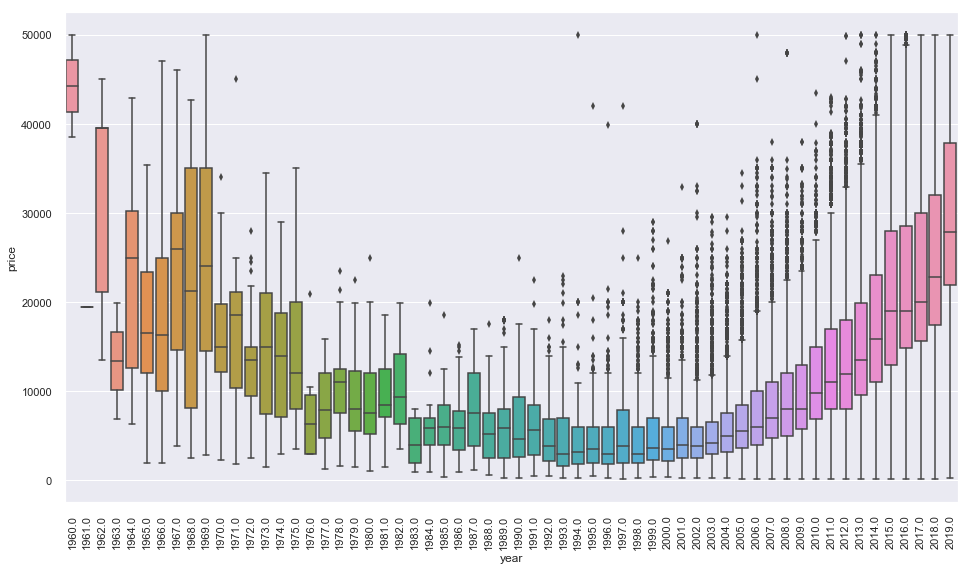

In [27]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=90)
sns.boxplot(x="year", y="price", data=df)

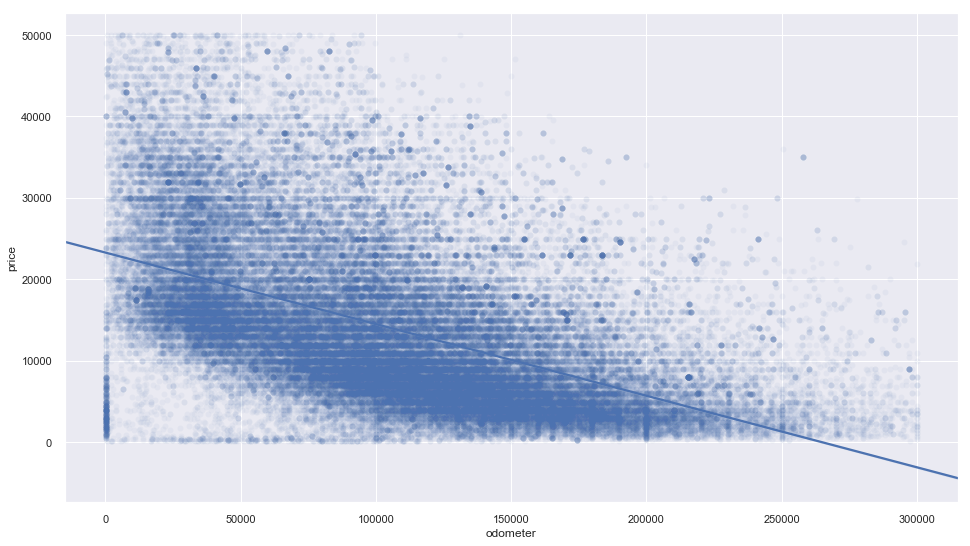

In [28]:
plt.figure(figsize=(16,9))
sns.regplot(x="odometer", y="price", data=df, scatter_kws={'alpha':0.05})

In this graphic it can be seen that the further a used car is driven, the cheaper the used car becomes.

We have many categorical variables, let's check their relationships to the price.

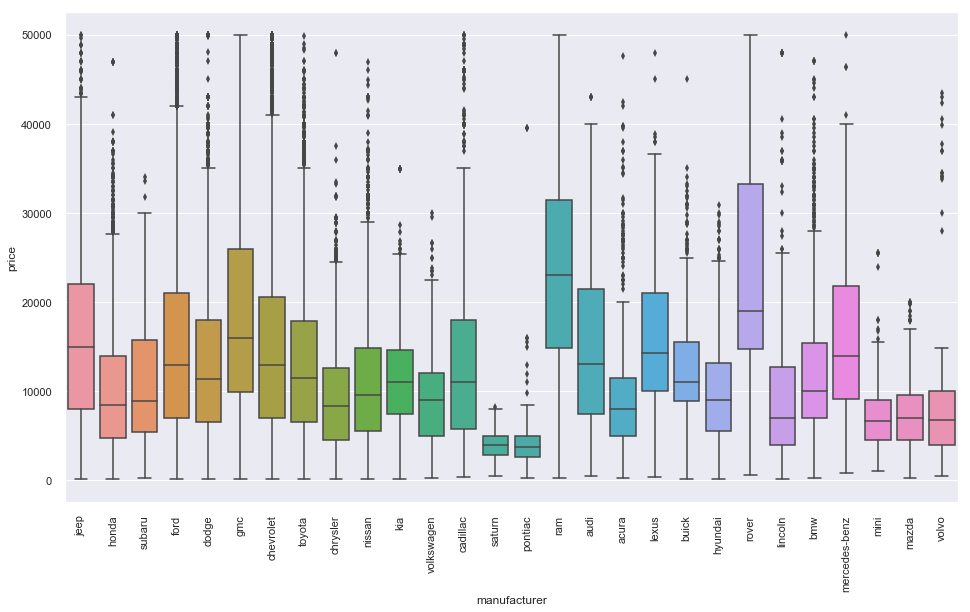

In [29]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=90)
sns.boxplot(x="manufacturer", y="price", data=df)

It can be seen that the price range of different manufacturers are very different. For example, GMC cars are offered in a wide price range from 100 to 50000 dollars. Used cars of the manufacturer Volvo however only from 100 to approx. 15000 dollars.

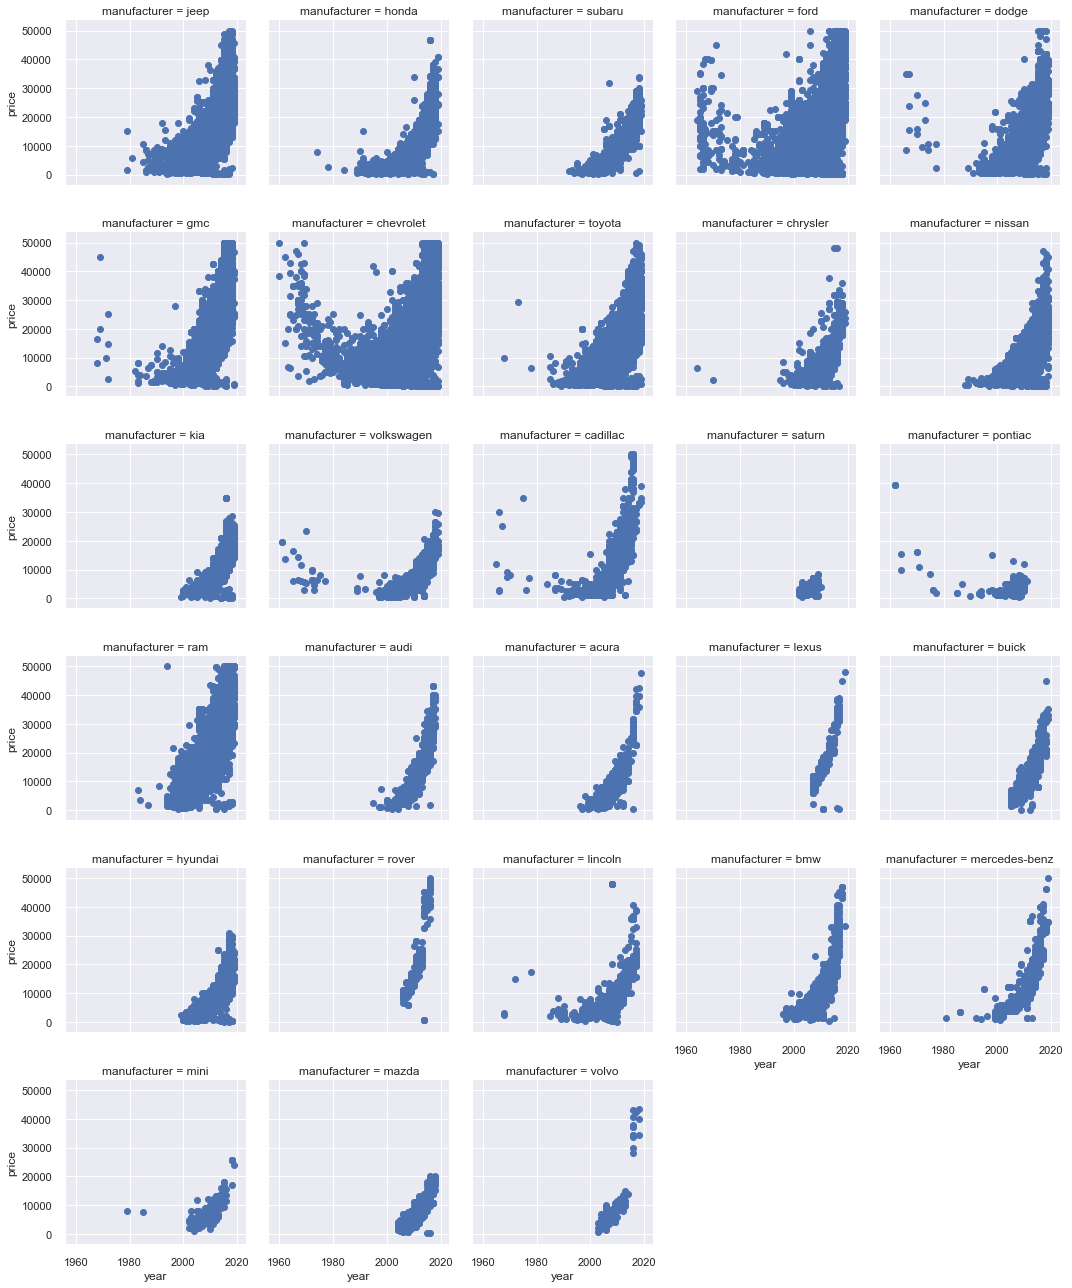

In [30]:
manufacturer_year_price = sns.FacetGrid(df, col="manufacturer", col_wrap=5)
manufacturer_year_price.map(plt.scatter, "year", "price")

This chart also reflects the price ranges of the different manufacturers, but after the year. For example, volvo only sells used cars produced after the year 2000. The newer the car, the more expensive it is traded. If you look at Chevrolet, on the other hand, it is noticeable that cars produced before the year 2000 are also offered here. It should be noted that older cars also increase in value here. Especially old and very new used cars are clearly more expensive than the used cars, which were produced around the year 2000.

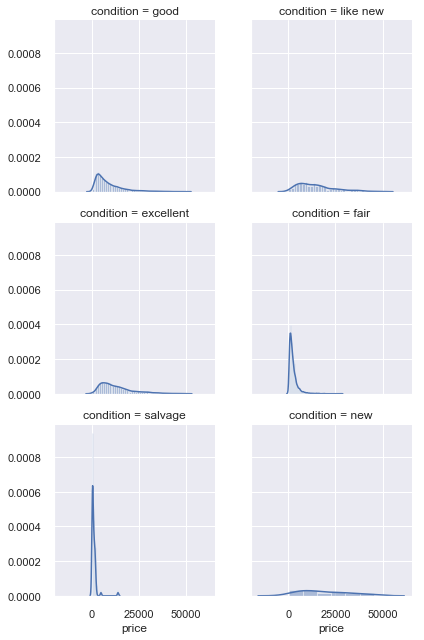

In [31]:
manufacturer_year_price = sns.FacetGrid(df, col="condition", col_wrap=2)
manufacturer_year_price.map(sns.distplot, "price",)

In these two graphics, the condition of the used car is considered depending on the price. For example, used cars with the condition "new" are distributed over the entire price interval. Used cars in the "salvage" status, however, are only available in a low price range. With the condition "excellent", on the other hand, you would expect particularly expensive used cars to have this condition, but there are mainly used cars in the price range 0 to 20000, which were indicated with this condition.

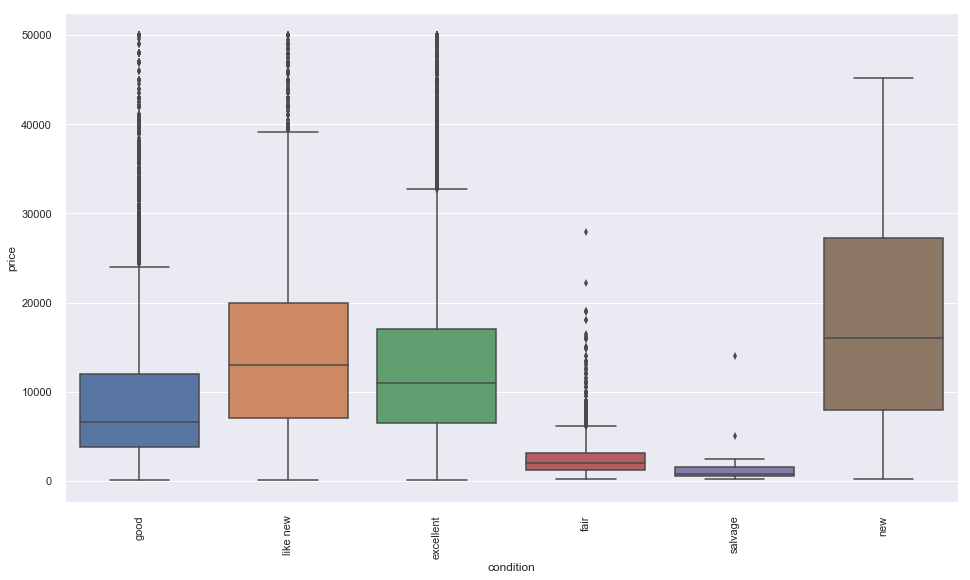

In [32]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=90)
sns.boxplot(x="condition", y="price", data=df)

## Hyperparameter Tuning and Saving Models

Some of the used models have a set hyperparameters that can be changed for each run. To find the optimal selection of these hyperparameters we use sklearns function `GridSearchCV`that helps to automatically try out and select the best hyperparameters.  

Since running the models takes time, the results are saved in the `Reports` folder.

# Linear Models (with regularization)
After the data has been cleaned up and a large number of incomplete and/or faulty data sets have been removed, the linear regression can now be applied to the tabular data to determine the price of a (used) car.

In [23]:
# Imports for the linear regression models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats

import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore")

In order to generate a training data set and a test data set from `df`, all variables must first be removed from which nothing can be learned (e.g. `car_id`) or variables which are unique and would generate too many dummy data (e.g. `lat` and `long`).

Dummy data is the conversion of categorical features into boolean variables. This is explained in the following example:

**Example Dataset:**

| manufacturer | color    |
|--------------|----------|
| Volvo        | black    |
| Chrysler     | red      |
| Daimler      | green    |

If you now generate dummies for the categorical variable `color` from this data set, the data set looks as follows:

**Generated Dataset:**

| manufacturer | black    | red      | green    |
|--------------|----------|----------|----------|
| Volvo        | 1        | 0        | 0        |
| Chrysler     | 0        | 1        | 0        |
| Daimler      | 0        | 0        | 1        |

In [24]:
# drop unnecessary variables that cause problems for further functions
df_regress = df.drop(columns=["url", "lat", "long", "image_url", "car_id", "priceCategory"])

# create year_quad because the relationship of year and price is more quadratic than linear
df_regress["year_quad"] = df_regress["year"] * df_regress["year"]

# categorical variables are converted to dummy variables
df_regress = pd.get_dummies(df_regress)

x_df_train, x_df_test, y_df_train, y_df_test = train_test_split(
                                                    df_regress.drop("price", axis=1),
                                                    df_regress["price"],
                                                    test_size=0.2,
                                                    random_state=42)
# Show the shapes of each split
print(x_df_train.shape)
print(x_df_test.shape)
print(y_df_train.shape)
print(y_df_test.shape)

(88629, 541)
(22158, 541)
(88629,)
(22158,)


Below is our OLS model. Since our dataset doesn't contain many variables we simple add manually step-by-step more variables and search for the model that has the lowest test RMSE. The overview of the step-by-step procedure can be found in `Reports/OLS Summary.xlsx`. 

We included:
* year and year squared
* odometer
* manufacturer
* condition
* cylinders
* fuel
* title_status
* transmission
* drive
* size
* type
* paint_color
* city



## OLS Regression

In [35]:
sklearnOLS = LinearRegression()
sklearnOLS.fit(x_df_train, y_df_train)

y_df_train_pred = sklearnOLS.predict(x_df_train)
y_df_test_pred = sklearnOLS.predict(x_df_test)

print(f'Training set error:\n{math.sqrt(mean_squared_error(y_df_train, y_df_train_pred))}')
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred))}')

Training set error:
4006.6361288402086
Test set error:
110253938.53930517


The simple OLS has an test error of about 4000 Dollars, maybe the predictions can be improved with advanced linear models such as the Ridge regression, Lasso regression or MARS. According to [(James, G. et al. (2013))](#James,-G.-et-al.-(2013)) the OLS regression tend to have high variance if the numbers of observations is not much bigger than the number of the variables. In our case the number of observations is very high, but nevertheless we want to try out these models.  

## Ridge Regression

While the least squares fitting procedure tries to minimize:
$$ RSS = \sum^{n}_{i = 1} \left( y_i - \beta_0 - \sum^{p}_{j = 1} \beta_j x_{ij} \right)^2 $$
the Ridge regression adds a shrinkage penalty to the minimization of RSS:
$$ RSS = \sum^{n}_{i = 1} \left( y_i - \beta_0 - \sum^{p}_{j = 1} \beta_j x_{ij} \right)^2 + \lambda \sum^{p}_{j = 1} \beta^{2}_{j}  $$
To find the best model we need first to standardize/normalize the predictors and then try out different values of the tuning parameter $\lambda$. A higher tuning parameter lowers the variance, but increases the bias of the model. 

In [ ]:
# here alpha parameter is the tuning parameter lambda
parameters = {"alpha" : list(np.append(np.arange(0, 1, 0.05),  np.arange(1, 21))),
            "fit_intercept" : [True, False],
            "normalize": [True],
            }

searchCV = GridSearchCV(Ridge(), 
                        parameters, 
                        cv=2,
                        n_jobs=-1,
                        verbose=10)

searchCV = searchCV.fit(x_df_train, y_df_train)

y_df_test_pred = searchCV.best_estimator_.predict(x_df_test)

print("The best model: ", searchCV.best_estimator_)
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred))}')

save_pickle_time(searchCV, "searchCV_Ridge")

In [37]:
ridge1 = read_pickle("searchCV_Ridge_2019-08-11--19-50-30")

y_df_train_pred = ridge1.best_estimator_.predict(x_df_train)
y_df_test_pred = ridge1.best_estimator_.predict(x_df_test)

print(f'Training set error:\n{math.sqrt(mean_squared_error(y_df_train, y_df_train_pred))}')
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred))}')

Training set error:
4508.4899848496
Test set error:
4632.123193863684


## Lasso Regression

The Lasso regression is very similiar to the ridge regression. The main difference is a small change in the penalty:

$$ RSS = \sum^{n}_{i = 1} \left( y_i - \beta_0 - \sum^{p}_{j = 1} \beta_j x_{ij} \right)^2 + \lambda \sum^{p}_{j = 1} |\beta_{j}|  $$

Compared to the ridge regression, the lasso regression does not shrink the coeffiecient towards zero, but can set them exactly to zero. It performs *variable selection*.



In [ ]:
# here alpha parameter is the tuning parameter lambda
parameters = {"alpha" : list(np.append(np.arange(0, 1, 0.05),  np.arange(1, 21))),
            "fit_intercept" : [True, False],
            "normalize": [True],
             "precompute": [True, False],
            }

searchCV = GridSearchCV(Lasso(), 
                        parameters,
                        cv=2,
                        n_jobs = -1,
                        verbose=10)

searchCV = searchCV.fit(x_df_train, y_df_train)

y_df_test_pred = searchCV.best_estimator_.predict(x_df_test)

print("The best model: ", searchCV.best_estimator_)
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred))}')

save_pickle_time(searchCV, "searchCV_lasso")

In [39]:
lasso1 = read_pickle("searchCV_lasso_2019-08-11--20-03-16")

y_df_train_pred = lasso1.best_estimator_.predict(x_df_train)
y_df_test_pred = lasso1.best_estimator_.predict(x_df_test)

print(f'Training set error:\n{math.sqrt(mean_squared_error(y_df_train, y_df_train_pred))}')
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred))}')

Training set error:
4512.684967616125
Test set error:
4636.010067812744


## MARS Regression

After the OLS regression we mentioned that it could be usefull to split up the regression, a model that could be us to improve our predicitons is the MARS model.
The multivariate adeptive regression splines is a special non-parametric regression technique that is able to automatically model non-linearities and interactions between variables. Before in the previous linear regression model we already included a polynomial variable, `year quad`. The MARS technique can help to find more such regressors. 

In this case we do not include the variable `year quad` from the dataset.

In [40]:
from pyearth import Earth

In [46]:
df_regress = df.drop(columns=["url", "lat", "long", "image_url", "car_id", "priceCategory"])

df_regress = pd.get_dummies(df_regress)

x_df_train, x_df_test, y_df_train, y_df_test = train_test_split(
                                                    df_regress.drop("price", axis=1),
                                                    df_regress["price"],
                                                    test_size=0.2,
                                                    random_state=42)
Mars = Earth()
Mars.fit(x_df_train, y_df_train)

y_df_train_pred = Mars.predict(x_df_train)
y_df_test_pred = Mars.predict(x_df_test)

print(f'Training set error:\n{math.sqrt(mean_squared_error(y_df_train, y_df_train_pred))}')
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred))}')

save_pickle_time(Mars, "mars")

Training set error:
4882.886609106775
Test set error:
4982.138626358963


In [48]:
Mars = read_pickle("mars_2019-08-31--21-27-39")

y_df_train_pred = Mars.predict(x_df_train)
y_df_test_pred = Mars.predict(x_df_test)

print(f'Training set error:\n{math.sqrt(mean_squared_error(y_df_train, y_df_train_pred))}')
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred))}')

Training set error:
4882.886609106775
Test set error:
4982.138626358963


In [49]:
print(Mars.summary())

Earth Model
----------------------------------------------
Basis Function           Pruned  Coefficient  
----------------------------------------------
(Intercept)              No      1.07096e+06  
h(odometer-140063)       No      16.4223      
h(140063-odometer)       No      -16.362      
drive_4wd                No      2133.01      
fuel_diesel              No      7482.34      
year                     No      610.077      
cylinders_4 cylinders    No      -2449.52     
drive_fwd                No      -1811.93     
type_pickup              No      4740.72      
type_truck               No      3826.61      
h(odometer-910)          No      -16.4536     
h(910-odometer)          Yes     None         
make_corvette            No      8359.44      
type_sedan               No      -1440.58     
manufacturer_toyota      No      2780.14      
make_wrangler            No      5795.46      
cylinders_8 cylinders    No      1473.71      
make_wrangler unlimited  No      8114.99      
m

## Results and Interpretation of OLS and Linear Models with Regularization

| Model           | Training set RMSE | Test set RMSE | 
|-----------------|------------------|--------------|
| 1)            OLS |     4014.95             |    4048.76          |
| 2)            Ridge|    4520.72           |    4583.40     |
| 3)            Lasso|    4524.80            |    4587.73        |
| 4)            Mars|    4891.67          |    4948.75         |

Suprisingly the advanced models do not help and the test errors RMSE remain above 4000 Dollars. Since we contain many categorical variables tree-based models could bring a more accurate prediction.

# Tree-Based Methods
To make a prediction for a dataset, it makes sense to establish different rules in order to further limit and specify the scope of a prediction.
The procedure in which the prediction space of an input is further and further restricted by defined rules is called decision trees. Decision trees can be used for regression and classification. [(James, G. et al. (2013))](#James,-G.-et-al.-(2013))

Furthermore, decision trees use a completely different approach compared to classical approaches such as linear regression.
In the case of price predictions of used cars, decision trees are likely to provide better results than e.g. linear regression, as decision trees can also map well non-linear relationships.
It can be assumed that the relationship between the features and the price is not linear.
[(James, G. et al. (2013))](#James,-G.-et-al.-(2013))

An approach to split the tree is by performing recursive binary splitting. First a predictor $ X_j $ and a cutpoint $ s $ are selected to create regions $ \{ X|X_j < s \} $ and $ \{ X|X_j \geq s \} $ that lead to the greatest reducton of the residual sum of squares, Basically we "consider all predictors $ X_1, ..., X_p $ and all possible values of the cutpoint $ s $ for each predictor, and then choose the predictor and the cutpoint such that the resulting tree has the lowest RSS. [(James, G. et al. (2013))](#James,-G.-et-al.-(2013)) So we define the pair of half-planes 

$$ R_1(j,s) =  \{ X|X_j < s \} \text{    and    } R_2(j,s) = \{ X|X_j \geq s \} $$

and we seek the value of $j$ and $s$ that minimize the equation [(James, G. et al. (2013))](#James,-G.-et-al.-(2013))

$$ \sum_{i: x_i \in R_1(j,s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j,s)} (y_i - \hat{y}_{R_2})^2 $$

Which is given by:

* $ j: $ j-th feature
* $ R_j: $ Amount of regions per feature
* $ i: $ i-th region
* $ y_i: $ Actual value in region $ i $
* $ \hat{y}_{R_j}: $ Estimated value for feature $ j $

Each split ends up with two new branches and is made by the greedy approach to get a better performance, because it selects at every point in the tree the locally best split and do not consider every possible feature parition. [(James, G. et al. (2013))](#James,-G.-et-al.-(2013))

<div style="text-align:center;">
<img src="./img/decision_tree.gif" alt="Building A Regression Tree" width="500" height="600"/>
<center>Source:  <a href="https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14">Building A Regression Tree</a>
</center>
</div>

To build a decision tree for a regression problem, the algorithms proceed as follows.
The data points, which should be predicted $Y$ based on features of the data $X$, can be represented in a graph (here the simplicity two-dimensional).
Now sectors in the graph become visible by certain splits in a decision tree.
After the decision tree was completely trained, the graph was divided into different sectors.
Data points within a sector have the property that they were classified with the same path in the decision tree.
If a new data set is added to the decision tree, this model only needs to look at the individual splits and run the path for which the split condition is True.
If this happens, the input data can be located in a sector in the graph and, for example, the price of a used car can be predicted with a certain error.
[(The Complete Guide to Decision Trees)](https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14)

In this section we will use different tree-based methods, since it is impossible to tell which method gives the best results we will try common methods and shortly describe their differences.

In [7]:
# All needed imports to train decision trees and make predictions

# pip install xgboost graphviz lightgbm catboost
import xgboost
import graphviz
import lightgbm
import catboost

from pdpbox import pdp
from scipy.stats import uniform, randint

from sklearn import tree
from sklearn import ensemble
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-whitegrid')
%matplotlib inline

Prepare the dataset by removing all features that prevent the decision trees from learning structures and thus do not add value to the viewing (e.g. the ID of the cars).
Then dummy variables are created.
How this works is explained in more detail in the chapter one hot encoding for neural networks [(One Hot Encoding)](#Data-Preparation-(with-One-Hot-Encoding)).

In [8]:
df_tree_1 = df.drop(columns=["url", "lat", "long", "image_url", "car_id", "priceCategory"])

# Create dummies for every variable
df_tree = pd.get_dummies(df_tree_1)

The data set is now prepared so that it can be divided into a training data set and a test data set.
The feature to be predicted has already been truncated and written to the appropriate control record.
To also test how the data set behaves when you determine decision trees for different price intervals, these are also created and divided accordingly.

In [10]:
x_df_train_tree, x_df_test_tree, y_df_train_tree, y_df_test_tree = train_test_split(
                                                    df_tree.drop("price", axis=1),
                                                    df_tree["price"],
                                                    test_size=0.2,
                                                    random_state=42)
print("Price (whole dataset): ", x_df_train_tree.shape, x_df_test_tree.shape, y_df_train_tree.shape, y_df_test_tree.shape)

# Generating the training and test sets for the given intervals
# Train and test sets for the interval [100, 25000]
df_tree_1 = df_tree[(df_tree.price >= 100) & (df_tree.price <= 25000)]
x_df_train_tree_1, x_df_test_tree_1, y_df_train_tree_1, y_df_test_tree_1 = train_test_split(
                                                    df_tree_1.drop("price", axis=1),
                                                    df_tree_1["price"],
                                                    test_size=0.2,
                                                    random_state=42)
print("Price in [100, 25000]: ", x_df_train_tree_1.shape, x_df_test_tree_1.shape, y_df_train_tree_1.shape, y_df_test_tree_1.shape)

# Train and test sets for the interval (25000, 50000]
df_tree_2 = df_tree[(df_tree.price > 25000) & (df_tree.price <= 50000)]
x_df_train_tree_2, x_df_test_tree_2, y_df_train_tree_2, y_df_test_tree_2 = train_test_split(
                                                    df_tree_2.drop("price", axis=1),
                                                    df_tree_2["price"],
                                                    test_size=0.2,
                                                    random_state=42)
print("Price in (25000, 50000]: ", x_df_train_tree_2.shape, x_df_test_tree_2.shape, y_df_train_tree_2.shape, y_df_test_tree_2.shape)

Price (whole dataset):  (88646, 540) (22162, 540) (88646,) (22162,)
Price in [100, 25000]:  (76567, 540) (19142, 540) (76567,) (19142,)
Price in (25000, 50000]:  (12079, 540) (3020, 540) (12079,) (3020,)


## Single Decision Tree (Classification and Regression Tree) Model
As described in the introduction, a regression decision tree is created at this point and trained on it using the training data so that the best feature splits are found and the decision tree is built.

### Single Decision Tree (with default parameter)

In [28]:
# Create a decision tree and fit it with the trainings data
cart_tree = tree.DecisionTreeRegressor()
cart_tree.fit(x_df_train_tree, y_df_train_tree)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [29]:
display(Markdown("**Results on the trainings data of the single decision tree without parameter:**"))
print("Score on the training data: " + str(cart_tree.score(x_df_train_tree, y_df_train_tree)))
train_preds_tree_01 = cart_tree.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(y_df_train_tree, train_preds_tree_01))))

display(Markdown("**Results on the test data of the single decision tree withour parameter:**"))
print("Score on the test data: " + str(cart_tree.score(x_df_test_tree, y_df_test_tree)))
test_preds_tree_01 = cart_tree.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(y_df_test_tree, test_preds_tree_01))))

**Results on the trainings data of the single decision tree without parameter:**

Score on the training data: 0.9998429258395873
Mean square error on the training data: 121.70187848738315


**Results on the test data of the single decision tree withour parameter:**

Score on the test data: 0.8877836121088705
Mean square error on the test data: 3290.13967195805


You can see that the decision tree is completely overfitted, because every price is determined is very exactly and the model fits up to 99% to the data.
This is also determined by the MSE, which is 121, so that the most data entires was correctly predicted.

Applying this model to the test data, it can be seen that the tree still has a relatively high precision in price determination, with 89% of all used cars correctly predicted.
Nevertheless, the RMSE is relatively high, because a price deviation of $3250.63 is relatively high for used cars.

Maybe other parameters can be adjusted to obtain a better result. This is done below for the decision tree.

### Single Decision Tree (with customized parameter)
To possibly create a better model of a decision tree, some parameters are now defined, such as when to set a split (random or optimality), whether to sort the data first or not, or how many data objects must be in at least one leaf for a leaf to exist.
These and other parameters are then tested using the automatic hyperparameter testing and the best result is returned.

To validate the respective model, 5-fold cross validation is used to validate the model on 5 splits of the training data.
This can be used at this point because there are enough data sets in the training data and the splits are not too small.
This has the advantage that a model can be validated 4 times without bias.

**Note:** Output is only documented in the table, because a rerun takes to much time.

In [ ]:
tree_parameters = {
    'splitter': ['best', 'random'],
    'max_depth':range(30, 100, 10),
    'min_samples_split': range(5, 30, 5),
    'min_samples_leaf':range(10, 100, 10),
    #'max_features':range(10,15),
    #'max_leaf_nodes':range(10, 50, 10),
    'random_state': [42],
    'presort': [True, False]
}

param_tree = tree.DecisionTreeRegressor()
param_tree = GridSearchCV(param_tree, tree_parameters, cv=5, n_jobs=-1, verbose=2) # cv=5 to use 5-fold cross-validation
param_tree.fit(x_df_train_tree, y_df_train_tree)

print("Best tree parameters that fits to defined conditions:")
print(param_tree.best_estimator_)

In [ ]:
display(Markdown("**Results on the trainings data of the single decision tree with parameter:**"))
print("Score on the training data: " + str(param_tree.score(x_df_train_tree, y_df_train_tree)))
train_preds_param_tree_01 = param_tree.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_param_tree_01
                                                                ))))

display(Markdown("**Results on the test data of the single decision tree with parameter:**"))
print("Score on the test data: " + str(param_tree.score(x_df_test_tree, y_df_test_tree)))
test_preds_param_tree_02 = param_tree.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(y_df_test_tree, test_preds_param_tree_02))))

By trying out different parameters to create a decision tree, the RMSE could unfortunately not be further minimized.
For this reason it can now be tried to use different decision trees for different price ranges.

The first tree should determine the prices of used cars in the price range $> 100$ to $<= 25000$.
The second decision tree is the used cars in the price range from $> 25000$ to $<= 50000$.

### Single Decision Tree (two price intervals)
To test whether better results are achieved, the data set is divided into price classes and decision trees are trained for the different classes.
So find and train decision trees for both intervals and adjust them to the training data.

In [33]:
# Tree for the intervall [100, 25000]
tree_100_25000 = tree.DecisionTreeRegressor()
tree_100_25000.fit(x_df_train_tree_1, y_df_train_tree_1)

# Tree for the intervall (25000, 50000]
tree_25000_50000 = tree.DecisionTreeRegressor()
tree_25000_50000.fit(x_df_train_tree_2, y_df_train_tree_2)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [34]:
# Train data for the price intervall [100, 25000]
display(Markdown("**Results for price interval [100, 25000]**"))
print("Score on the train data: " + str(tree_100_25000.score(x_df_train_tree_1, y_df_train_tree_1)))
train_preds_tree_100_25000 = tree_100_25000.predict(x_df_train_tree_1)
print("Mean square error on the train data: " + str(math.sqrt(mean_squared_error(y_df_train_tree_1, train_preds_tree_100_25000))))

# Test data for the price intervall [100, 25000]
print("Score on the test data: " + str(tree_100_25000.score(x_df_test_tree_1, y_df_test_tree_1)))
test_preds_tree_100_25000 = tree_100_25000.predict(x_df_test_tree_1)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(y_df_test_tree_1, test_preds_tree_100_25000))))

**Results for price interval [100, 25000]**

Score on the train data: 0.9996891418915239
Mean square error on the train data: 110.4720187698647
Score on the test data: 0.8223490135745658
Mean square error on the test data: 2635.260388899536


In [35]:
# Train data for the price intervall (25000, 50000]
display(Markdown("**Results for price interval (25000, 50000]**"))
print("Score on the train data: " + str(tree_25000_50000.score(x_df_train_tree_2, y_df_train_tree_2)))
train_preds_tree_25000_50000 = tree_25000_50000.predict(x_df_train_tree_2)
print("Mean square error on the train data: " + str(math.sqrt(mean_squared_error(y_df_train_tree_2, train_preds_tree_25000_50000))))

# Test data for the price intervall (25000, 50000]
print("Score on the test data: " + str(tree_25000_50000.score(x_df_test_tree_2, y_df_test_tree_2)))
test_preds_tree_25000_50000 = tree_25000_50000.predict(x_df_test_tree_2)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(y_df_test_tree_2, test_preds_tree_25000_50000))))

**Results for price interval (25000, 50000]**

Score on the train data: 0.9991906684899416
Mean square error on the train data: 167.33393736638394
Score on the test data: 0.560078726571001
Mean square error on the test data: 4033.8257800744295


If you now further change the interval limits to for example:
* (100, 20000) and \[20000, 50000)
* (100, 25000) and \[25000, 50000)
* (100, 30000) and \[30000, 50000)
* (100, 35000) and \[35000, 50000)

It can be seen that this does not necessarily contribute to an improvement in the estimated price.
For this reason, further experimentation may be needed.
It may also make sense to not only create two price intervals and divide the used cars into more expensive and cheaper, but several price intervals, so that subclass, middle class and upper class used cars can be better considered.

## Random Forest Model
Random forest in general allows to create more than only one decision tree to predict in our case the price.
To make decisions more precise, it is better not to rely only on the result of a single decision tree, but to create several decision trees and select the average result from them. [(Breiman L. (2001))](#Breiman,-L.-(2001))

There are two different ways to create these different trees before combining them.
On the one hand, "bagging" exists, whereby the models are created in parallel and independently of each other with randomized data.  The idea is to create B-many traning sets from the original training set, to build sepearate prediction models ($ \hat{f} $) and then to average the resulting prediction. 

$$ \hat{f}_{bag} (x) = \frac{1}{B} \sum^{B}_{b=1} \hat{f}^{*b}(x) $$

Trees that are created with "bagging" are grown deep, and are not pruned.
On the other hand, "boosting" exists, whereby the models are created sequentially and each model can learn from the errors of the predecessor model.
The random forest uses the bagging approach in combination with random data selection. [(Breiman L. (2001))](#Breiman,-L.-(2001)). Instead of taking all predictors in each model the random forest approach randomly selects m-many predictors. It is recommendend to set m = square root of number of predictiors. The reason to avoid many predictors is that a strong predictor, will always be at the top split of a bagged tree. By this all the trees are highly correlated with each other. By this "averaging many highly correlated trees does not lead to a large reduction of variance as averaging many uncorrelated trees" [(James, G. et al. (2013))](#James,-G.-et-al.-(2013)).

### Standard Random Forest Model

In [37]:
random_forest = ensemble.RandomForestRegressor(
                    n_estimators=500,
                    criterion="mse",
                    #max_depth=50,
                    #min_samples_split=10,
                    #min_samples_leaf=15,
                    max_features="sqrt",
                    #max_features="log2",
                    #max_leaf_nodes=100,
                    bootstrap=True, # Samples are used to build the trees
                    n_jobs=-1,
                    random_state=1234, # Sets a seed 1234 to regenerate the results
                    #warm_start=True, # Reuses the result of the tree before
                    verbose=2
    )

random_forest.fit(x_df_train_tree, y_df_train_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 500building tree 2 of 500building tree 3 of 500building tree 4 of 500



building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s


building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.3s


building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=1234, verbose=2,
                      warm_start=False)

In [38]:
display(Markdown("**Results for the training data with a random forest:**"))
print("Score on the training data: " + str(random_forest.score(x_df_train_tree, y_df_train_tree)))
train_preds_random_forest_01 = random_forest.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_random_forest_01
                                                                    ))))

display(Markdown("**Results for the test data with a random forest:**"))
print("Score on the test data: " + str(random_forest.score(x_df_test_tree, y_df_test_tree)))
test_preds_random_forest_01 = random_forest.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_test_tree,
                                                                    test_preds_random_forest_01
                                                                    ))))

**Results for the training data with a random forest:**

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   10.0s finished


Score on the training data: 0.9900802927574209


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    9.5s finished


Mean square error on the training data: 967.1511125651801


**Results for the test data with a random forest:**

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.2s finished


Score on the test data: 0.9303462354736494


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.1s finished


Mean square error on the test data: 2592.140209786942


If the results of the Random Forest are compared with the previous approaches, it is noticeable that this approach does not overfit as much and produces significantly better results on the entire test data than a simple single decision tree.
The Root Mean Squared Error has now dropped to 2592 for the test set.
The price range estimated with this error, however, is still much too large for a used car, so it makes sense to test other models such as boosting models.
Since the Random Forest approach produced good results, it makes sense to further develop this model and follow the Extremly Randomized Trees approach.

### Extremely Randomized Trees

The *Extra-Tree* "method drops the idea of using bootstrap copies of the learning sample, and instead of trying to find an optimal cut-point for each one of the K randomly chosen features at each node, it selects a cut-point at random". [(Geurts et al. (2005))](#Geurts-et-al.-(2005)) and [(Quora (2017)](#Quora-Question-(2017)).

The hyper parameter tuning of this model took even on the cluster more than two hours and the saved `.pickle` file is more than 1.5 gigabyte huge. Therefore we only provide the best model according to the tuning.

In [39]:
from sklearn.ensemble import ExtraTreesRegressor

extremly_rand_trees = ExtraTreesRegressor(
    bootstrap=False,
    criterion="mse",
    max_depth=None,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=200, 
    n_jobs=-1,
    oob_score=False,
    random_state=None,
    verbose=2,
    warm_start=False,
)

extremly_rand_trees = extremly_rand_trees.fit(x_df_train_tree, y_df_train_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200building tree 4 of 200


building tree 5 of 200building tree 6 of 200

building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min



building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 7

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min


building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.8min finished


In [40]:
display(Markdown("**Results for the training data with a random forest:**"))
print("Score on the training data: " + str(extremly_rand_trees.score(x_df_train_tree, y_df_train_tree)))
train_preds_extremly_rand_trees_01 = extremly_rand_trees.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_extremly_rand_trees_01
                                                                    ))))

display(Markdown("**Results for the test data with a random forest:**"))
print("Score on the test data: " + str(extremly_rand_trees.score(x_df_test_tree, y_df_test_tree)))
test_preds_extremly_rand_trees_01 = extremly_rand_trees.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_test_tree,
                                                                    test_preds_extremly_rand_trees_01
                                                                    ))))

**Results for the training data with a random forest:**

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.5s finished


Score on the training data: 0.9998428611541971


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished


Mean square error on the training data: 121.72693519677708


**Results for the test data with a random forest:**

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished


Score on the test data: 0.9387428731760974


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.8s finished


Mean square error on the test data: 2430.8855037579606


In [11]:
extrat = read_pickle("ExtraTrees_bestmodel_2019-08-17--17-14-16")

y_df_train_tree_pred = extrat.predict(x_df_train_tree)
y_df_test_tree_pred = extrat.predict(x_df_test_tree)

print(f'Training set error:\n{math.sqrt(mean_squared_error(y_df_train_tree, y_df_train_tree_pred))}')
print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test_tree, y_df_test_tree_pred))}')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    8.0s
[Para

Training set error:
115.578747728195
Test set error:
2447.1477081168928


In [12]:
x_df_test_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22162 entries, 472158 to 16124
Columns: 540 entries, year to paint_color_yellow
dtypes: float64(2), uint8(538)
memory usage: 11.9 MB


In [13]:
df_x_template = x_df_test_tree.copy()
df_y_template = y_df_test_tree.copy()

In [18]:
df_x_template = df_x_template[0:0]
df_x_template

,year,odometer,city_SF bay area,city_akron / canton,"city_albany, NY",city_albuquerque,"city_amarillo, TX",city_anchorage / mat-su,"city_ann arbor, MI","city_annapolis, MD",...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow


In [26]:
x = ["paint_color_brown", "city_albany, NY"]
x

['paint_color_brown', 'city_albany, NY']

In [28]:
for i in x:
    for j in df_x_template.columns:
        if i == j:
            print(j)
            df_x_template.loc[1, j] = 1
        
df_x_template

paint_color_brown
city_albany, NY


,year,odometer,city_SF bay area,city_akron / canton,"city_albany, NY",city_albuquerque,"city_amarillo, TX",city_anchorage / mat-su,"city_ann arbor, MI","city_annapolis, MD",...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


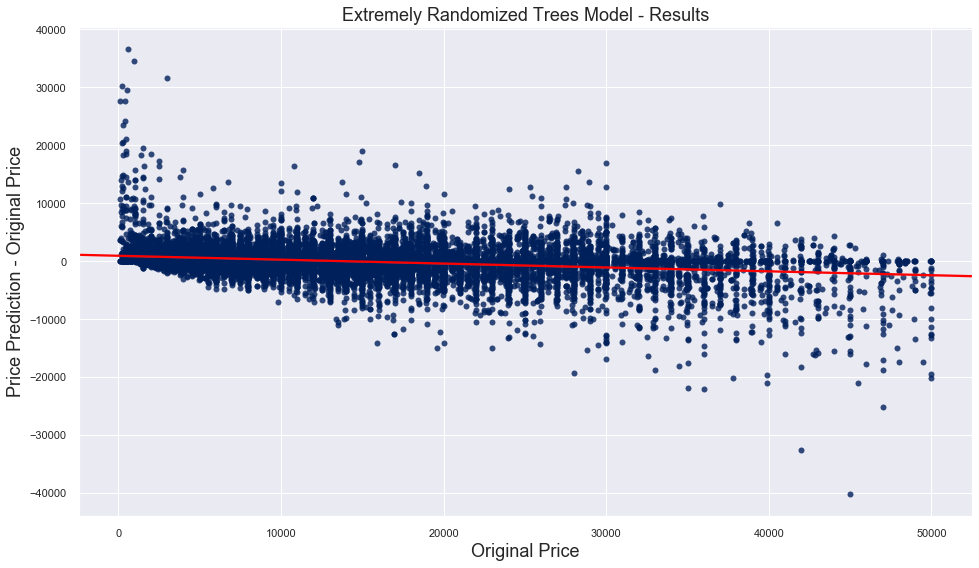

In [25]:
fig = sns.regplot(y_df_test_tree, y_df_test_tree_pred-y_df_test_tree, scatter_kws={"color": "#00205b"}, line_kws={"color": "red"})
plt.xlabel("Original Price", fontsize=18)
plt.ylabel("Price Prediction - Original Price", fontsize=18)
plt.title("Extremely Randomized Trees Model - Results", fontsize=18)
plt.show(fig)

<img src="..\Reports\extrastrees-report.png" width="600px">

Particularly about the extremely randomized trees is that the RMSE on the training data is very low and the model with an accuracy of 0.99% fits the data very well, so you can assume that the model is over-fitted, but on the training data it delivers the best result so far and managed to lower the RMSE again by about 100 dollars from the previously best result of the Random Forest.

## Boosting Models

While the bagging methods, like the random forest algorithm, try to reduce variance the boosting methods try to reduce variance and bias. They do not boot strap the data, but are able to modify it by using weights or residuals. 

The following part contains different boosting models

### Gradient Boosting Model

The first tree is build by using the average *price*. Obviously it is far of the origin values and results in high residuals. These residuals are used for the second tree. The second tree tries to predicict the residuals. Now the first tree predictions are added to the product of a *learning rate* and the predictions of the second tree to build new predictions. Again these prediction results in residuals, but they are smaller than before. The new residuals are used for the third tree that is then added again to the previous trees. This procedure will be repeated until a certain condition is met, for example if the residuals do not get significant better after a new tree.

In [91]:
gradient_boosting_model = ensemble.GradientBoostingRegressor(
                                loss='lad',
                                learning_rate=0.1,
                                n_estimators=100,
                                subsample=1.0,
                                criterion='friedman_mse',
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_depth=3,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                init=None,
                                random_state=None,
                                max_features=None,
                                alpha=0.9,
                                verbose=2,
                                max_leaf_nodes=None,
                                warm_start=False,
                                presort='auto',
                                validation_fraction=0.1,
                                n_iter_no_change=None,
                                tol=0.0001
                            )

gradient_boosting_model.fit(x_df_train_tree, y_df_train_tree)

      Iter       Train Loss   Remaining Time 
         1        6994.9928            3.10m
         2        6578.1037            2.84m
         3        6198.3781            2.66m
         4        5886.4636            2.61m
         5        5595.5449            2.54m
         6        5348.8998            2.49m
         7        5143.7842            2.44m
         8        4946.0556            2.39m
         9        4764.8113            2.37m
        10        4593.9572            2.34m
        11        4451.7066            2.29m
        12        4316.8556            2.25m
        13        4199.2683            2.22m
        14        4096.5604            2.17m
        15        3997.3009            2.14m
        16        3924.4621            2.10m
        17        3840.6731            2.07m
        18        3773.4156            2.03m
        19        3713.2833            1.99m
        20        3651.4828            1.95m
        21        3598.0493            1.92m
        2

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=2, warm_start=False)

In [92]:
display(Markdown("**Results for the training data with the gradient boosting model:**"))
print("Score on the training data: " + str(gradient_boosting_model.score(x_df_train_tree, y_df_train_tree)))
train_preds_gradient_boosting_model_01 = gradient_boosting_model.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_gradient_boosting_model_01
                                                                    ))))

display(Markdown("**Results for the test data with the gradient boosting model:**"))
print("Score on the test data: " + str(gradient_boosting_model.score(x_df_test_tree, y_df_test_tree)))
test_preds_gradient_boosting_model_01 = gradient_boosting_model.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_test_tree,
                                                                    test_preds_gradient_boosting_model_01
                                                                    ))))

**Results for the training data with the gradient boosting model:**

Score on the training data: 0.8193016310802929
Mean square error on the training data: 4127.832103535397


**Results for the test data with the gradient boosting model:**

Score on the test data: 0.8172837178935947
Mean square error on the test data: 4198.313032668049


The results of the first test with a boosting model, went surprisingly bad, since the RMSE on the Train Set and Test Set has risen again to over 4000, so that this model is not profitable for the data set.

### XGBoost Model
This approach is based on a linear model (this approach can also be based on logistic regression, etc., but in this case linear regression makes more sense) by giving the weighted features as input to determine the price of used cars in this case. [(Introduction to Boosted Trees)](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)

Please note that random forests and gradient boosted trees are the same models, but are trained differently.
In XGBoost's standard gradient boosted models are used to train the decision tree.
The purpose of XGBoost is that multiple regression trees are treated additively, thus creating an objective function which is a sum of multiple trees. [(Introduction to Boosted Trees)](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)

#### Regression Model with XGBoost
Furthermore XGBoost has three big advantages to deliver good results in a short time.
XGBoost tries to build the tree sequentially and can parallelize the individual splits. There is also a difference when pruning the trees.
Because this happens here "backwards", which improves the computing power considerably.
In order to deliver good results with good performance, more complex models are punished by L1 or L2 regularization if they adapt too much to the data.
In addition, this approach has a built-in cross-validation method for each iteration, allowing the exact number of required boost iterations to be determined in a single pass.
[(XGBoost Algorithm)](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [93]:
xgboost_tree = xgboost.XGBRegressor(
    booster = 'gbtree',
    n_estimators=500,
    objective ='reg:squarederror', # 'reg:linear' is deprecated
    n_jobs=-1,
    verbosity=2
)

xgboost_tree.fit(x_df_train_tree, y_df_train_tree)

[23:08:22] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:08:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:08:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:08:23] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:08:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:08:24] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=2)

In [94]:
display(Markdown("**Results for the training data with the xgboost regression tree model:**"))
print("Score on the training data: " + str(xgboost_tree.score(x_df_train_tree, y_df_train_tree)))
train_preds_xgboost_tree_01 = xgboost_tree.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_xgboost_tree_01
                                                                    ))))

display(Markdown("**Results for the test data with the xgboost regression tree model:**"))
print("Score on the test data: " + str(xgboost_tree.score(x_df_test_tree, y_df_test_tree)))
test_preds_xgboost_tree_01 = xgboost_tree.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_test_tree,
                                                                    test_preds_xgboost_tree_01
                                                                    ))))

**Results for the training data with the xgboost regression tree model:**

Score on the training data: 0.8846459192296512
Mean square error on the training data: 3298.081546405444


**Results for the test data with the xgboost regression tree model:**

Score on the test data: 0.8784460460980105
Mean square error on the test data: 3424.291575173048


Performing a regression model using XGBoost improves the RMSE on both datasets by about 800, but the extremly randomized trees and the random forest already produced much better results.

#### Random Forest with XGBoost
Random Forest with XGBoost uses the same model representation as the regression with xgboost, but uses a different method to train the model. It is supposed perform higher and be more efficient. [(Random Forests in XGBoost)](https://xgboost.readthedocs.io/en/latest/tutorials/rf.html)

In [95]:
xgboost_random_forest = xgboost.XGBRFRegressor(
    objective ='reg:squarederror', # 'reg:linear' is deprecated
    #subsample = 0.6,
    n_estimators=500,
    random_state = 42,
    n_jobs=-1,
    verbosity=2
)

xgboost_random_forest.fit(x_df_train_tree, y_df_train_tree)

[23:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:13:49] INFO: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
               n_jobs=-1, nthread=None, objective='reg:squarederror',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=2)

In [96]:
display(Markdown("**Results for the training data with the xgboost random forest model:**"))
print("Score on the training data: " + str(xgboost_random_forest.score(x_df_train_tree, y_df_train_tree)))
train_preds_xgboost_random_forest_01 = xgboost_random_forest.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_xgboost_random_forest_01
                                                                    ))))

display(Markdown("**Results for the test data with the xgboost random forest model:**"))
print("Score on the test data: " + str(xgboost_random_forest.score(x_df_test_tree, y_df_test_tree)))
test_preds_xgboost_random_forest_01 = xgboost_random_forest.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_test_tree,
                                                                    test_preds_xgboost_random_forest_01
                                                                    ))))

**Results for the training data with the xgboost random forest model:**

Score on the training data: 0.6408988126385864
Mean square error on the training data: 5819.066612757137


**Results for the test data with the xgboost random forest model:**

Score on the test data: 0.641340282089756
Mean square error on the test data: 5882.033499277007


Interestingly enough, the random forest with XGBoost performs even worse than all previous models, so that this approach can be rejected for the current problem. The RMSE on the Train Set has increased to 5819 and on the Test Set to 5882.

### LightGBM Model
In contrast to the approaches used so far to create decision trees, the LightGBM Framework uses a different approach.
LightGBM allows the tree to grow vertically and thus decides at each node specifically which feature is considered next.
LightGBM lets the decision tree grow leafwise.
In contrast, the previously used algorithms create the tree horizontally and level by level.
Furthermore it is capable to deal with huge amounts of data efficiently whereas other tree algorithms struggle. 
Additionally it is possible to use GPUs for calculation, which makes it attractive for the bigger projects. 
One disadvantage is, that it tends to overfit on small datasets, but as this dataset comprises about 110000 valid rows of data, it should be applicable.
[(Guolin Ke et. al. (2017))](#Guolin-Ke-et-al.-(2017))
[(What is LightGBM, How to implement it?)](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [97]:
%%capture
# %%capture will hide the cell output

# Create LightGBM data containers

train_data_lightgbm = lightgbm.Dataset(x_df_train_tree, 
                                       y_df_train_tree)

test_data_lightgbm = lightgbm.Dataset(x_df_test_tree,
                                      y_df_test_tree)

# Train the LightGBM model
lightgbm_parameters = {
    'task': 'train',
    'objective': 'regression',
    'boosting': 'gbdt',
    #'boosting': 'dart',
    'num_iterations': 200,
    'learning_rate': 0.1,
    'num_leaves': 250,
    #'tree_learner': 'feature',
    'tree_learner': 'serial',
    'num_threads': 4,
    'device_type': 'cpu',
    'seed': 1234,
    'max_depth': 55,
    'metric': 'l2',
    'is_unbalance': True,
    'feature_fraction': 0.5,
    #'verbosity': 0
}

lightgbm_model = lightgbm.train(lightgbm_parameters,
                       train_data_lightgbm,
                       valid_sets=test_data_lightgbm,
                       num_boost_round=5000,
                       early_stopping_rounds=100,
                       feature_name="auto",
                       categorical_feature= "auto")

In [98]:
display(Markdown("**Results for the training data with lightgbm:**"))
u = (lightgbm_model.predict(x_df_train_tree)-y_df_train_tree).pow(2).sum()
v = (y_df_train_tree-y_df_train_tree.mean()).pow(2).sum()
print("Score on the training data: " + str(1-(u/v)))
train_preds_lightgbm_01 = lightgbm_model.predict(x_df_train_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_lightgbm_01
                                                                    ))))

display(Markdown("**Results for the test data with lightgbm:**"))
u = (lightgbm_model.predict(x_df_test_tree)-y_df_test_tree).pow(2).sum()
v = (y_df_test_tree-y_df_test_tree.mean()).pow(2).sum()
print("Score on the test data: " + str(1-(u/v)))
test_preds_lightgbm_01 = lightgbm_model.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_test_tree,
                                                                    test_preds_lightgbm_01
                                                                    ))))

del u,v

**Results for the training data with lightgbm:**

Score on the training data: 0.9554267679721467
Mean square error on the test data: 2050.132692812705


**Results for the test data with lightgbm:**

Score on the test data: 0.9318302748319889
Mean square error on the test data: 2564.377536205309


The LightGBM approach produces a relatively good result in the first attempt compared to the other models, but the result is still worse than that of the random forests and the extremly randomized trees.

### CatBoost Model
CatBoost is based on a gradient amplification, which supposedly exceeds the existing boosting algorithms like XGBoost and Light GBM.
Unlike XGBoost or Light GBM, CatBoost doesn't need to be trained with data for long to get good results. It is also not necessary to try out the hyper parameters using GridSearch, as different models are trained for different data points.
To avoid training too many models, the number of models is limited to $\log(\text{number_of_datapoints})$ by default.
In addition, a model trained to the first data point is included in the calculation of the model of the second data point and the second is included in the third and so on.
Another main difference between CatBoost and other tree-based algorithms is that it uses symmetrical trees. This helps to shorten the prediction time. [(What’s so special about CatBoost?)](https://medium.com/@hanishsidhu/whats-so-special-about-catboost-335d64d754ae)

CatBoost also has a good representation of categorical features, which are displayed as vectors by default and encoded using one hot encoding.
However, CatBoost is designed for categorical variables and takes longer than LightGBM for many numerical features. However, the data set considered here has almost exclusively categorical variables, so CatBoost is suitable for the application in this case. [(What’s so special about CatBoost?)](https://medium.com/@hanishsidhu/whats-so-special-about-catboost-335d64d754ae)

In [99]:
catboost_model = catboost.CatBoostRegressor(iterations=500,
                             learning_rate=0.10,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

catboost_model.fit(x_df_train_tree, y_df_train_tree,
             eval_set=(x_df_test_tree, y_df_test_tree),
             use_best_model=True,
             verbose=50)

0:	learn: 15506.8896088	test: 15696.5390809	best: 15696.5390809 (0)	total: 1.78s	remaining: 14m 50s
50:	learn: 3272.4875677	test: 3416.6768296	best: 3416.6768296 (50)	total: 1m 10s	remaining: 10m 18s
100:	learn: 2910.1007478	test: 3116.4616022	best: 3116.4616022 (100)	total: 2m 25s	remaining: 9m 34s
150:	learn: 2680.3831855	test: 2951.9473098	best: 2951.9473098 (150)	total: 3m 38s	remaining: 8m 24s
200:	learn: 2503.1605281	test: 2844.7608538	best: 2844.7608538 (200)	total: 4m 47s	remaining: 7m 8s
250:	learn: 2362.0690374	test: 2766.7858666	best: 2766.7858666 (250)	total: 5m 56s	remaining: 5m 53s
300:	learn: 2243.8912013	test: 2708.3389664	best: 2708.3389664 (300)	total: 7m 10s	remaining: 4m 44s
350:	learn: 2143.0308058	test: 2662.5424523	best: 2662.5424523 (350)	total: 8m 20s	remaining: 3m 32s
400:	learn: 2053.7581287	test: 2623.6763403	best: 2623.6763403 (400)	total: 9m 29s	remaining: 2m 20s
450:	learn: 1970.3726177	test: 2590.6085643	best: 2590.6085643 (450)	total: 10m 39s	remaining:

In [100]:
display(Markdown("**Results for the training data with the catboost model:**"))
print("Score on the training data: " + str(catboost_model.score(x_df_train_tree, y_df_train_tree)))
train_preds_catboost_model_01 = catboost_model.predict(x_df_train_tree)
print("Mean square error on the training data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_train_tree,
                                                                    train_preds_catboost_model_01
                                                                    ))))

display(Markdown("**Results for the test data with the catboost model:**"))
print("Score on the test data: " + str(catboost_model.score(x_df_test_tree, y_df_test_tree)))
test_preds_catboost_model_01 = catboost_model.predict(x_df_test_tree)
print("Mean square error on the test data: " + str(math.sqrt(mean_squared_error(
                                                                    y_df_test_tree,
                                                                    test_preds_catboost_model_01
                                                                    ))))

**Results for the training data with the catboost model:**

Score on the training data: 0.9617835504363149
Mean square error on the training data: 1898.322856201233


**Results for the test data with the catboost model:**

Score on the test data: 0.9318936173890829
Mean square error on the test data: 2563.1858636507973


With the CatBoost model it is noticeable that the RMSE is slightly lower than the previous approaches on the train set. Also the RMSE on the test set is good, so that the two best models are now extremly randomized trees followed by catboost.

## Results of all Decision Tree Approaches

<table style="width:100%">
  <tr>
    <th>Approach</th>
    <th>Accuracy Training</th>
    <th>RMSE* Training</th>
    <th>Accuracy Test</th>
    <th>RMSE* Test</th>
  </tr>
  <tr>
    <td>Single Decision Tree (CART)</td>
    <td>0.9998</td>
    <td>121.7018</td>
    <td>0.8877</td>
    <td>3290.1396</td>
  </tr>
  <tr>
    <td>Single Decision Tree (CART) with parameter</td>
    <td>0.9183</td>
    <td>2775.1197</td>
    <td>0.8816</td>
    <td>3378.9815</td>
  </tr>
  <tr>
    <td>Single Decision Tree (CART) with price constraint $$(100 \leq price \leq 25000)$$</td>
    <td>0.9996</td>
    <td>110.4720</td>
    <td>0.8223</td>
    <td>2635.2603</td>
  </tr>
  <tr>
    <td>Single Decision Tree (CART) with price constraint $$(25000 < price \leq 50000)$$</td>
    <td>0.9991</td>
    <td>167.3339</td>
    <td>0.5600</td>
    <td>4033.8257</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.9900</td>
    <td>967.1511</td>
    <td>0.9303</td>
    <td>2592.1402</td>
  </tr>
  <tr>
    <td>Extra Randomized Trees</td>
    <td>0.9998</td>
    <td>121.7269</td>
    <td>0.9387</td>
    <td>2430.8855</td>
  </tr>
  <tr>
    <td>Gradient Boosting Model</td>
    <td>0.8193</td>
    <td>4127.8321</td>
    <td>0.8172</td>
    <td>4198.3130</td>
  </tr>
  <tr>
    <td>Regression Model with XGBoost</td>
    <td>0.8846</td>
    <td>3298.0815</td>
    <td>0.8784</td>
    <td>3424.2915</td>
  </tr>
  <tr>
    <td>Random Forest with XGBoost</td>
    <td>0.6408</td>
    <td>5819.0666</td>
    <td>0.6413</td>
    <td>5882.0334</td>
  </tr>
  <tr>
    <td>LightGBM</td>
    <td>0.9554</td>
    <td>2050.1326</td>
    <td>0.9318</td>
    <td>2564.3775</td>
  </tr>
  <tr>
    <td>CatBoost</td>
    <td>0.9617</td>
    <td>1898.3228</td>
    <td>0.9318</td>
    <td>2563.1858</td>
  </tr>
</table> 
 
\*RMSE = Root Mean Squared Error

In summary, it can be seen that the accuracy on the training data is consistently good, except for the Random Forest with XGBoost approach.
Accuracy is just 64%.
THE RMSE on the training data set reflects this accuracy and is therefore relatively low at a high accuracy.
This can be a hint for overfitting.
On the test set, the results are generally worse, with Single Decision Tree (CART) with price constraint $(25000 < price \leq 50000)$ as well as Random Forest with XGBoost with particularly bad results standing out.
The best results on the test set were delivered by Extra Randomized Tree (RMSE of 2430.8855) and the CatBoost approach (RMSE of 2563.1858).

# Neural Network (for tabular data)
In order to be able to make price predictions for used cars in the following, the approach of neural networks is used. These are implemented using Keras, which is a high-level Python API for TensorFlow. [(Keras Documentation)](https://keras.io/)

At the beginning therefore further imports of packages are necessary to implement a neural network and to access the Keras API.

In [41]:
# Imports to use neural networks
import tensorflow.keras
# Print the used Keras version that every team meber uses the same package version
tensorflow.keras.__version__

from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras.optimizers import RMSprop, Adam, Nadam
from keras.activations import relu, elu, softmax, softplus, tanh, linear, exponential, sigmoid
from keras.losses import mean_absolute_error as mae, mean_squared_error as mse
from keras.callbacks import ModelCheckpoint

# Print the local available devices to run a nerual network
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Use sklearn function to get a train/test split and calculate the MSE or MAE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# Use talos to test automatically different parameters for a neural network 
import talos as ta
from talos.model.layers import hidden_layers
from talos.model.normalizers import lr_normalizer

# Use category_encoders package to encode categorical variables in binary or numerical variables
import category_encoders

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14634572136981618207
]


## Data Preparation
As with previous approaches such as regression and decision trees, the data must be prepared in order to achieve good results in price determination with neural networks.

For this reason, at the beginning, all columns are removed from the data set from which nothing can be learned and which would represent a very great effort in encoding, such as the URL of an image, or the ID of a car.
Furthermore, all cells in the data set that contain the value `NaN` are replaced by the string 'none' in order to categorically capture this value as well. For example, the colors of used cars have the categories 'green', 'blue', ... as well as 'none'.

In [42]:
# Delete all columns with data from which nothing can be learned
df_nn = df.drop(columns=["url", "lat", "long", "image_url", "car_id", "priceCategory"])

# Fill all values with NaN with the string 'none' to get this at category
df_nn = df_nn.fillna('none')

To make sure that now all unnecessary features given in the dataset have been removed, this is checked again by outputting all columns of the dataset.

Cells that input of the neural network should include:
```python
['city', 'price', 'year', 'manufacturer', 'make', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
```

In [43]:
# Print all left columns in the dataset
df_nn.columns

Index(['city', 'price', 'year', 'manufacturer', 'make', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color'],
      dtype='object')

In order to get an overview of the different features in relation to the other features, these are plotted in the following in a table.

In [44]:
# Get an overview of the different features 

# df_nn.groupby('city').nunique()
# df_nn.groupby('manufacturer').nunique()
# df_nn.groupby('make').nunique()
# df_nn.groupby('condition').nunique()
# df_nn.groupby('cylinders').nunique()
# df_nn.groupby('fuel').nunique()
# df_nn.groupby('title_status').nunique()
# df_nn.groupby('transmission').nunique()
# df_nn.groupby('drive').nunique()
# df_nn.groupby('size').nunique()
# df_nn.groupby('type').nunique()
df_nn.groupby('paint_color').nunique()

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
paint_color,,,,,,,,,,,,,,,
black,280,3429,56,28,175,7,8,5,10154,1,3,3,5,12,1
blue,280,1961,58,28,175,7,8,4,5203,1,3,3,5,12,1
brown,273,692,47,27,161,7,8,4,1244,1,3,3,5,12,1
custom,258,1540,51,28,171,6,8,5,2682,1,3,3,5,12,1
green,276,693,43,27,156,7,7,5,1482,1,3,3,5,12,1
grey,280,2243,43,28,174,7,8,4,5692,1,3,3,5,12,1
none,280,3033,49,28,175,7,8,5,8522,1,3,3,5,12,1
orange,176,287,32,19,82,6,5,4,317,1,3,3,5,11,1
purple,113,115,32,20,75,6,7,2,145,1,3,3,5,11,1


Now all other categorical Features of the data set are stored in a list in order to encode them in the different encoding methods. What exactly is meant by encoding is described in more detail below.
At this point we will start encoding the different categorical features, which means converting categorical values into numbers so that they can used as an input for the neural network.
This is necessary, because neural networks uses algebraic functions to learn and predict something.
This means that their input have to be numerical.
So categories must be transformed into numbers first, before a neural network can be applied on them.

In [45]:
categorical_columns = [
    'city', 'manufacturer', 'make', 'condition',
    'cylinders', 'fuel', 'title_status', 'transmission',
    'drive', 'size', 'type', 'paint_color'
]

### Data Preparation (with Ordinal Encoding)
The first method to encode categorical data in a data set is the ordinal encoding.
Here the idea is that the liberty exists to assign random numbers to the categories according to the business use case.
The only constraint is, that no number can be assigned twice.
To illustrate this better, the process will be explained in more detail in the next example.

**Example:**

Data Table before Ordinal Encoding:
<table width="50%">
  <tr>
    <th>car_id</th>
    <th>country</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>1</td>
    <td>France</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Denmark</td>
  </tr>
</table> 

Data Table after Ordinal Encoding:
<table width="50%">
  <tr>
    <th>car_id</th>
    <th>country*</th>
  </tr>
  <tr>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>2</td>
  </tr>
</table>

\*Encoded with the following mapping:
* Germany &#8594; 0
* France &#8594; 1
* Denmark &#8594; 2

In [46]:
# Create for every categorical feature a list with all possible values
# For example the varialbe `city_labels` includes all cities that are present in the dataset `df_nn`
city_labels = df_nn['city'].astype('category').cat.categories.tolist()
manufacturer_labels = df_nn['manufacturer'].astype('category').cat.categories.tolist()
make_labels = df_nn['make'].astype('category').cat.categories.tolist()
condition_labels = df_nn['condition'].astype('category').cat.categories.tolist()
cylinders_labels = df_nn['cylinders'].astype('category').cat.categories.tolist()
fuel_labels = df_nn['fuel'].astype('category').cat.categories.tolist()
title_status_labels = df_nn['title_status'].astype('category').cat.categories.tolist()
transmission_labels = df_nn['transmission'].astype('category').cat.categories.tolist()
drive_labels = df_nn['drive'].astype('category').cat.categories.tolist()
size_labels = df_nn['size'].astype('category').cat.categories.tolist()
type_labels = df_nn['type'].astype('category').cat.categories.tolist()
paint_color_labels = df_nn['paint_color'].astype('category').cat.categories.tolist()

# Create a dictionary which includes the mapping between the original values and the ordinal values
ordinal_mapping = {
    'city': {k: v for k,v in zip(city_labels,list(range(1,len(city_labels)+1)))},
    'manufacturer': {k: v for k,v in zip(manufacturer_labels,list(range(1,len(manufacturer_labels)+1)))},
    'make': {k: v for k,v in zip(make_labels,list(range(1,len(make_labels)+1)))},
    'condition': {k: v for k,v in zip(condition_labels,list(range(1,len(condition_labels)+1)))},
    'cylinders': {k: v for k,v in zip(cylinders_labels,list(range(1,len(cylinders_labels)+1)))},
    'fuel': {k: v for k,v in zip(fuel_labels,list(range(1,len(fuel_labels)+1)))},
    'title_status': {k: v for k,v in zip(title_status_labels,list(range(1,len(title_status_labels)+1)))},
    'transmission': {k: v for k,v in zip(transmission_labels,list(range(1,len(transmission_labels)+1)))},
    'drive': {k: v for k,v in zip(drive_labels,list(range(1,len(drive_labels)+1)))},
    'size': {k: v for k,v in zip(size_labels,list(range(1,len(size_labels)+1)))},
    'type': {k: v for k,v in zip(type_labels,list(range(1,len(type_labels)+1)))},
    'paint_color': {k: v for k,v in zip(paint_color_labels,list(range(1,len(paint_color_labels)+1)))}
}

# Displays the mapping 
print(ordinal_mapping)

{'city': {'SF bay area': 1, 'akron / canton': 2, 'albany, NY': 3, 'albuquerque': 4, 'amarillo, TX': 5, 'anchorage / mat-su': 6, 'ann arbor, MI': 7, 'annapolis, MD': 8, 'appleton-oshkosh-FDL': 9, 'asheville, NC': 10, 'athens, GA': 11, 'atlanta, GA': 12, 'auburn, AL': 13, 'austin, TX': 14, 'bakersfield, CA': 15, 'baltimore, MD': 16, 'baton rouge': 17, 'bellingham, WA': 18, 'bemidji, MN': 19, 'bend, OR': 20, 'billings, MT': 21, 'binghamton, NY': 22, 'birmingham, AL': 23, 'bloomington-normal': 24, 'boise, ID': 25, 'boston': 26, 'boulder, CO': 27, 'bowling green, KY': 28, 'bozeman, MT': 29, 'brainerd, MN': 30, 'buffalo, NY': 31, 'cape cod / islands': 32, 'cedar rapids, IA': 33, 'central NJ': 34, 'central michigan': 35, 'champaign urbana': 36, 'charleston, SC': 37, 'charleston, WV': 38, 'charlotte, NC': 39, 'charlottesville, VA': 40, 'chattanooga, TN': 41, 'chicago': 42, 'chico, CA': 43, 'cincinnati, OH': 44, 'clarksville, TN': 45, 'cleveland, OH': 46, 'colorado springs': 47, 'columbia / jef

In order not to modify the original data, a copy of it is created.
The original data, which has already been prepared for the neural network, is also required for further encoding procedures.
Within the copied original data `df_nn_ordinal` the respective categorical values can now be replaced by the ordinal values assigned in the mapping.

In [47]:
# Create a copy of the original data
df_nn_ordinal = df_nn.copy()

# Replace each categorical value with the listener value from the ordinal mapping.
df_nn_ordinal.replace(ordinal_mapping, inplace=True)
df_nn_ordinal.head()

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
357,2,10999,2006.0,13,167,3,6,3,126912.0,1,2,1,3,1,10
358,2,11499,2005.0,13,167,3,6,3,104033.0,1,1,1,2,1,1
359,2,8499,2008.0,11,15,4,4,3,57024.0,1,1,2,1,10,7
361,2,8499,2010.0,25,74,3,4,3,102967.0,1,1,1,2,5,6
366,2,11950,2003.0,9,66,3,8,1,179147.0,1,1,1,2,9,12


With the output above it can be observed, that every category was encoded with the mapped numbers.
This can also be checked with the `dtype` of an encoded column, which should only contain integer values.

In [48]:
# Print for example the value type in the column `city` (Should contain only integers).
print(df_nn_ordinal['city'].dtypes)

int64


Finally, all categorical features are typecasted with the integer values to the type `categorical` to perform operations on the dataframe faster.

In [49]:
# Typecast object values as categorical values
for column in categorical_columns:
    df_nn_ordinal[column] = df_nn_ordinal[column].astype('category')

The problem that arises is that the neuronal network may learn nonsensical structures that are false in reality and do not exist.
For example, the neural network could learn the following structure:

$$ \frac{1}{2}\cdot \text{France} = \text{Germany} $$

Of course, this structure makes no sense, since different countries do not have a connection in reality that can be modelled in this way.
[(Categorical Data)](https://www.datacamp.com/community/tutorials/categorical-data)

### Data Preparation (with One Hot Encoding)
The strategy pursued with OneHot Encoding is that each categorical value is created as a new column and filled with 0 or 1.
In this case, 0 and 1 are to be understood as True or False.
The advantage of this is that no incorrect weighting or logically incorrect calculation of the values is possible.
To illustrate this approach better, the next example will explain this approach. [(Scikit Learn OneHot Encoding)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

**Example:**

Data Table before OneHot Encoding:
<table width="50%">
  <tr>
    <th>car_id</th>
    <th>country</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>1</td>
    <td>France</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Denmark</td>
  </tr>
</table> 

Data Table after OneHot Encoding:
<table width="50%">
  <tr>
    <th>car_id</th>
    <th>Germany</th>
    <th>France</th>
    <th>Denmark</th>
  </tr>
  <tr>
    <td>0</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>0</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>0</td>
    <td>0</td>
    <td>1</td>
  </tr>
</table>

In order not to change the original data in this step, a copy of the data was also created.
The OneHot encoding is finally done using the method `get_dummies` of the `Pandas` API.
This returns new columns (dummy/indicator variables) as described in the above example, where a 1 is set if the property applies, and a 0 if the property does not apply.
The original feature column will be delete during this process. [(Scikit Learn OneHot Encoding)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [50]:
# Create a copy of the original data
df_nn_onehot = df_nn.copy()

# Create dummy variables for every categorical feature
df_nn_onehot = pd.get_dummies(df_nn_onehot, columns=categorical_columns, prefix = categorical_columns)

In [51]:
# Print the head of the dataframe
df_nn_onehot.head()

,price,year,odometer,city_SF bay area,city_akron / canton,"city_albany, NY",city_albuquerque,"city_amarillo, TX",city_anchorage / mat-su,"city_ann arbor, MI",...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_none,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
357,10999,2006.0,126912.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
358,11499,2005.0,104033.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
359,8499,2008.0,57024.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
361,8499,2010.0,102967.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
366,11950,2003.0,179147.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


OneHot Encoding is a good tool for preventing the relation or weighting of unrelated categorical variables of a feature through a neural network.
It should be noted, however, that even OneHot encoding can become useless if categorical variables have too many values and for this reason a lot of new columns are generated, which increases the dimensionality of the data extremely.
In high dimensional spaces it becomes too difficult to recognize structures in the data.

### Data Preparation (with Binary Encoding)

The approach of binary encoding is a bit more complicated than Ordinal Encoding or OneHot Encoding.
Basically the binary encoding is similar to the OneHot Encoding.
The difference here is that the categories are not stored in independent columns, but each category is represented by a bit sequence. [(Categorical Encoding Scikit Learn)](https://contrib.scikit-learn.org/categorical-encoding/binary.html)

Here the categorical features like ordinal encoding are mapped to consecutive integer numbers first.
However, the integer number is then rewritten as a binary number.
The digits of the binary number are then each written as a column in the data frame. ([(Binary Encoding Towards Data Science)](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159) and [(Binary Encoding Datacamp)](https://www.datacamp.com/community/tutorials/categorical-data))

**Example:**

Data Table before Binary Encoding:
<table width="50%">
  <tr>
    <th>car_id</th>
    <th>country</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>1</td>
    <td>France</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Germany</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Denmark</td>
  </tr>
</table> 

Data Table after Binary Encoding:
<table width="50%">
  <tr>
    <th>car_id</th>
    <th>country_0</th>
    <th>country_1</th>
  </tr>
  <tr>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>1</td>
    <td>0</td>
  </tr>
</table>

As can be seen in the example, the columns were first encoded using Ordinal Encoding. This was done as follows:
* Germany &#8594; 0
* France &#8594; 1
* Denmark &#8594; 2

The largest number, which was created by the ordinal encoding, is the number $2$. Two bits are needed to represent this in the binary number system. For this reason two new columns `country_0` and `county_1` are created. The previous feature column `country` will be removed. The ordinally encoded numbers are now converted into the binary system and written into the columns as shown in the table. For example the number $2$ (in decimal system) will be converted to $(10)_2$ ([(Binary Encoding Towards Data Science)](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159) and [(Binary Encoding Datacamp)](https://www.datacamp.com/community/tutorials/categorical-data))

The `category_encoder` package from Scikit Learn is used here to implement the binary encoding. [(Binary Encoder Scikit Learn)](https://contrib.scikit-learn.org/categorical-encoding/binary.html)

In [52]:
# Create a copy of the original data
df_nn_binary = df_nn.copy()

# Creation of a binary encoder
binary_encoder = category_encoders.BinaryEncoder(cols=categorical_columns)
# Converting categorical columns using the binary encoder
df_nn_binary = binary_encoder.fit_transform(df_nn_binary)

In [53]:
# Print the head of the dataframe
df_nn_binary.head()

,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,type_0,type_1,type_2,type_3,type_4,paint_color_0,paint_color_1,paint_color_2,paint_color_3,paint_color_4
357,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
358,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
359,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
361,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0
366,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,1


The advantage compared to the OneHot Encoding is that with many categories of a feature, the dimensions of the data set do not expand enormously, but fewer dimensions are produced.
This approach is therefore well suited for data with a higher dimensionality.
The fewer features can also be related by a neural network, without which incorrect not real correlations are learned, since the columns contain only zeros and ones.
Thus the problem of ordinal encoding is solved. ([(Binary Encoding Towards Data Science)](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159) and [(Binary Encoding Datacamp)](https://www.datacamp.com/community/tutorials/categorical-data))

The problem with this approach is that it is problematic to encode categorical features with only a few features in this way, since then structures for the neural network may be more difficult to recognize, since there may be some collisions between the binary numbers. If a feature has many categories, the probability of collisions is automatically reduced, so the approach can produce much better results. ([(Binary Encoding Towards Data Science)](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159) and [(Binary Encoding Datacamp)](https://www.datacamp.com/community/tutorials/categorical-data))

### Data Preparation Limitations
What has to be considered, and not looked at in detail due to time problems, is that it can make sense not to use a single encoding for all features on the whole dataset, but to decide separately for each feature which feature would make the most sense.
For example, it makes sense to use the OneHot Encoding for the `paint_color` column, since this feature has relatively few categories, as opposed to the `make` feature, which contains the exact model of the cars.
For this feature, Binary Encoding would probably make more sense. [(Binary Encoding Towards Data Science)](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)

It should also be noted that these are the three most commonly used types of data encoding and that there are several other types of encoding.
We have identified the best known types by the extent to which known platforms propose to encode data, such as Datacamp and Towards Data Science. [(Binary Encoding Towards Data Science)](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)
Further approaches to encoding data would be the following:

* **Hashing Encoders:** This approach works similar to One Hot Encoding, but it produces fewer dimensions, which also means a loss of information, since small numbers of columns for categories can cause collisions with other categories.

* **Backward Difference Encoding:** This compares the mean value of the dependent variable for a level of a categorical variable with the mean value of the dependent variable for the previous level. So if you have a set of $n$ classes $C$ with different classes $c_i \in C$, the respective influence of the class $c_i$ on the difference of the expected value that the output $y$ is classified in class $c_i$ is minus the general expected value of the output $y$. [(Processor for Predictive Modeling)](https://arxiv.org/pdf/1611.09477v3.pdf) This can be illustrated as follows (given that $c_1,c_2,c_3,\ldots,c_n \in C$):
$$\text{Impact}(c_i) = E(y|c_i) - E(y) \qquad \text{with   } i \in \{1,2,3,\ldots,n\}$$
This approach allows encoded categorical variables to be compared, but makes more sense when the different categories of a feature are related, which is not actually the case in this dataset. [(Contrast Coding Systems for categorical variables)](https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/#backward)

* Many more

## Create Train, Validation and Test Split
Now that three known encoding options have been introduced and applied to the data set, the necessary splits of the data set are created in the following.
In this notebook, a split describes a section of the total data set to be examined. [(About Train, Validation and Test Sets in Machine Learning Towards Data Science)](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)
The following splits of the data set are created:
* **Training Split:** The training data set contains a sample of data which is used for training or adaptation of the neural network. This data set contains of the 80 % of the original data set 60 % and is randomly compiled with a seed. The seed is used to assign the same data to the training data set on different devices or after repeated execution.
* **Validation Split:** The validation data set includes a sample of data that is used to provide an unbiased assessment of a model that has been trained using the training data set while further adjusting the model parameters. The validation data set is 40 % of the training data set.
* **Test Split:** The test data set includes a sample of data used to provide an unbiased assessment of a final model trained using the training data set. The final model is then checked for correctness using this data set. This data set contains the remaining 20% of the original data set.

This partitioning can be illustrated in the following tree:
<ul class="tree">
    <li>Original Dataset</li>
    <ul>
        <li>1. Split (80 %)</li>
        <ul>
            <li>Training Split (60 %)</li>
            <li>Validation Split (40 %)</li>
        </ul>
        <li>1. Split (20 %)</li>
        <ul>
            <li>Test Split (20 %)</li>
        </ul>
    </ul>
</ul>

In [54]:
########################################################################################################
############################                ORDINAL ENCODING          ##################################
########################################################################################################

# Generate a train and test set for the data with ordinal encoding
x_df_train_nn_ordinal, x_df_test_nn_ordinal, y_df_train_nn_ordinal, y_df_test_nn_ordinal = train_test_split(
                                                    df_nn_ordinal.drop("price", axis=1),
                                                    df_nn_ordinal["price"],
                                                    test_size=0.2,
                                                    random_state=42)

# Split train set again to get a training and validation set for the ordinal encoding
x_df_train_nn_ordinal_train, x_df_train_nn_ordinal_val = np.split(x_df_train_nn_ordinal, [int(.6*len(x_df_train_nn_ordinal))])
y_df_train_nn_ordinal_train, y_df_train_nn_ordinal_val = np.split(y_df_train_nn_ordinal, [int(.6*len(y_df_train_nn_ordinal))])

display(Markdown("**Train and test data for ORDINAL ENCODING:**"))
print("Shapes of train set: ", x_df_train_nn_ordinal_train.shape, y_df_train_nn_ordinal_train.shape)
print("Shapes of validation set: ", x_df_train_nn_ordinal_val.shape, y_df_train_nn_ordinal_val.shape)
print("Shapes of test set: ", x_df_test_nn_ordinal.shape, y_df_test_nn_ordinal.shape)
print("Shapes of whole data set: ", df_nn_ordinal.shape)


########################################################################################################
############################              ONE HOT ENCODING            ##################################
########################################################################################################

# Generate a train and test set for the data with one hot encoding
x_df_train_nn_onehot, x_df_test_nn_onehot, y_df_train_nn_onehot, y_df_test_nn_onehot = train_test_split(
                                                    df_nn_onehot.drop("price", axis=1),
                                                    df_nn_onehot["price"],
                                                    test_size=0.2,
                                                    random_state=42)

# Split train set again to get a training and validation set for the one hot encoding
x_df_train_nn_onehot_train, x_df_train_nn_onehot_val = np.split(x_df_train_nn_onehot, [int(.6*len(x_df_train_nn_onehot))])
y_df_train_nn_onehot_train, y_df_train_nn_onehot_val = np.split(y_df_train_nn_onehot, [int(.6*len(y_df_train_nn_onehot))])

display(Markdown("**Train and test data for ONE HOT ENCODING:**"))
print("Shapes of train set: ", x_df_train_nn_onehot_train.shape, y_df_train_nn_onehot_train.shape)
print("Shapes of validation set: ", x_df_train_nn_onehot_val.shape, y_df_train_nn_onehot_val.shape)
print("Shapes of test set: ", x_df_test_nn_onehot.shape, y_df_test_nn_onehot.shape)
print("Shapes of whole data set: ", df_nn_onehot.shape)


########################################################################################################
############################                BINARY ENCODING           ##################################
########################################################################################################

# Generate a train and test set for the data with binary encoding
x_df_train_nn_binary, x_df_test_nn_binary, y_df_train_nn_binary, y_df_test_nn_binary = train_test_split(
                                                    df_nn_binary.drop("price", axis=1),
                                                    df_nn_binary["price"],
                                                    test_size=0.2,
                                                    random_state=42)

# Split train set again to get a training and validation set for the binary encoding
x_df_train_nn_binary_train, x_df_train_nn_binary_val = np.split(x_df_train_nn_binary, [int(.6*len(x_df_train_nn_binary))])
y_df_train_nn_binary_train, y_df_train_nn_binary_val = np.split(y_df_train_nn_binary, [int(.6*len(y_df_train_nn_binary))])

display(Markdown("**Train and test data for BINARY ENCODING:**"))
print("Shapes of train set: ", x_df_train_nn_binary_train.shape, y_df_train_nn_binary_train.shape)
print("Shapes of validation set: ", x_df_train_nn_binary_val.shape, y_df_train_nn_binary_val.shape)
print("Shapes of test set: ", x_df_test_nn_binary.shape, y_df_test_nn_binary.shape)
print("Shapes of whole data set: ", df_nn_binary.shape)

**Train and test data for ORDINAL ENCODING:**

Shapes of train set:  (53177, 14) (53177,)
Shapes of validation set:  (35452, 14) (35452,)
Shapes of test set:  (22158, 14) (22158,)
Shapes of whole data set:  (110787, 15)


**Train and test data for ONE HOT ENCODING:**

Shapes of train set:  (53177, 544) (53177,)
Shapes of validation set:  (35452, 544) (35452,)
Shapes of test set:  (22158, 544) (22158,)
Shapes of whole data set:  (110787, 545)


**Train and test data for BINARY ENCODING:**

Shapes of train set:  (53177, 61) (53177,)
Shapes of validation set:  (35452, 61) (35452,)
Shapes of test set:  (22158, 61) (22158,)
Shapes of whole data set:  (110787, 62)


## Price Prediction with Simple Sequential Neural Networks

In this section we will try to determine the price of used cars with the help of neuronal networks using the previously prepared data.
At the beginning a simple sequential neural network is created, which allows to create a neural network adding layer by layer.
This procedure for creating a neural network is described by Keras as a standard procedure, since it is listed directly as the first item in the Getting Started chapter [(Keras Getting Started)](https://keras.io/getting-started/sequential-model-guide/).
Sequential in this context means that the neural network consists of different layers (input layer, hidden layer(s) and output layer), which are attached one behind the other.
To create a sequential neural network it is necessary to import Keras and use its API.

Thus the input (previously prepared tabular data) is passed to the first layer (input layer). The input data is processed here and, if existent, in other hidden layers, so that edge weights are adjusted between the different sequential layers in the neural network. The neural network is then able to output a prediction about the output layer. It is not necessary to specify patterns, because the neural network is able to recognize them itself. [(Building A Deep Learning Model using Keras)](https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37)

The following is an exemplary graphic of a sequential neural network with one input and output layer and two hidden layers.

<div style="text-align:center;">
<img src="img/structure_neural_network.jpg" alt="Example Structure of a Neural Networks" width="500" height="600"/> 
<center>Source:  <a href="https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37">Building A Deep Learning Model using Keras</a> 
</center>
</div>

The following layers and components are used in the following neural networks [(Building A Deep Learning Model using Keras)](https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37):
* **Dense Layer:** A dense layer is a standard layer type that works for most cases. In a dense layer are all nodes from the the previous layer connected to the nodes in the current layer. The number of nodes can be set to very high amount, but this increases the model capacity and possibly leads to overfitting.
* **Activation Function:** An activation function allows nonlinear relationships to be taken into account. A node in a neural network only forwards the incoming "signal" caused by the edge weight if the input used in the activation function reaches a certain threshold value. For the layers used, several activation functions were tested to provide good results.
* **Flatten Layer:** A flatten layer flattens the input data. So if a multi-dimensional dataset, like the dataset with features of used cars, will be flatten, the data become one-dimensional. So the features are not left in columns, but simply written in a column. Your data set with the shape $(10,5)$ becomes a data set with the one-dimensional shape $(50)$ ($10 \cdot 5=50$). However, it should be noted that this approach is more suitable for images and is therefore only used later in image processing.

In the following, a sequential neural network is trained for each encoding variant and tested on the test data to find out which of the three encoding variants delivers the best results in pricing used cars.

The steps to get a model and its results are as follows:
* Define a sequential neural network with different layers and compile it (Enter different model parameters like activation function or amount of layers manually and test these different configurations)
* Create a checkpoint list to save every model which produces an better result than the model of the epochs before
* Train and validate the model on the associated data set (During the training and validation the `mean_squared_error` will be used as the metric to decide, if a model is useful or not)
* Plot the train and validation history
* Calculate the RMSE\* in case of the predicted values of the validation and test set with the actual values
* Plot the actual and predicted prices for the first 500 used cars in one graph to see how good the model fits to the real data

After a single model has been manually adjusted and evaluated, the [Talos API](https://autonomio.github.io/talos/#/) was used to automatically test different hyperparameter configurations of the models to find the most optimal configuration. Each model that was better than that of the previous epochs was saved.

\* RMSE = Root Mean Squared Error

### Simple Sequential Neural Network (with Ordinal Encoding)
First we try to train a neural network using ordinal encoded data.

The following hyperparameter configuration was tested manually:
* Activation functions: relu, softmax, softplus, tanh, linear, exponential, sigmoid, elu
* Numbers of hidden layers:
    * Numbers of dropout layers: 0, 1, 2, 3
    * Numbers of dense layers: 0, 1, 2, ..., 7, 8
* Dropout rate: 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5
* Nodes in each layer: 1, 5, 10, 20, 32, 64, 128, 256, 512

In [ ]:
# Define a sequential model
simple_nn_ordinal = Sequential()

# Define the input layer
simple_nn_ordinal.add(Dense(10, input_shape=(x_df_train_nn_ordinal.shape[1],), kernel_initializer='normal', activation='relu'))

# Define the hidden layers
simple_nn_ordinal.add(Dense(64, kernel_initializer='normal', activation='relu'))
simple_nn_ordinal.add(Dropout(0.2))
simple_nn_ordinal.add(Dense(10, kernel_initializer='normal', activation='relu'))

# Define the output layer
simple_nn_ordinal.add(Dense(1, kernel_initializer='normal', activation='relu'))

# Compile the model
simple_nn_ordinal.compile(loss='mean_squared_error', optimizer=RMSprop(), metrics=['mean_squared_error'])

# Print a model summary
simple_nn_ordinal.summary()

In order to make the best model accessible at any time, checkpoints of the current model are created if it produces a better result than the one in the previous epoch. Better result means lower RMSE. These checkpoints from complete models are important for reusing the fully trained model later.

Now that the data has been prepared and split into respective splits and the model of a neural network has been defined, it is possible to train this model using the training data and adjust the edge weights to align the predicted price as close as possible to the real price.
To train the model using the data, the feature columns are passed without the price and the price in a separate dataframe.
In addition, further parameters were defined which influence the progress of the training.
The `batch_size` was set to the default from the lecture (32), so that 32 lines of the data set are viewed simultaneously to detect structures.
Furthermore, the neural network is trained for 50 `epochs` and the validation data sets are transferred to the neural network in order to validate the model impartially in each epoch.

In [ ]:
# Define checkpoint name syntax
checkpoint_name = '../Models/neural_networks/simple_nn_ordinal/simple_nn_ordinal-manual-{val_loss:.5f}.hdf5'
# Create checkpoint
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# Add the checkpoint to a list to proof if the actual model is better than the models before
callbacks_list = [checkpoint]

# Start to train the model
simple_nn_ordinal_history = simple_nn_ordinal.fit(
    x_df_train_nn_ordinal_train, y_df_train_nn_ordinal_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_df_train_nn_ordinal_val, y_df_train_nn_ordinal_val),
    callbacks=callbacks_list,
    verbose=2
)

To see if 50 epochs were sufficient to train the model or even too much, it makes sense to have a look at the model history. It shows the epochs on the x-axis and the error on the training or validation data on the y-axis. If in later epochs the loss is oscillating, it indicates that it is not worthwhile to train the model over 50 epochs at all.

The train loss is represented with the blue line and the validation loss is displayed with the red line.

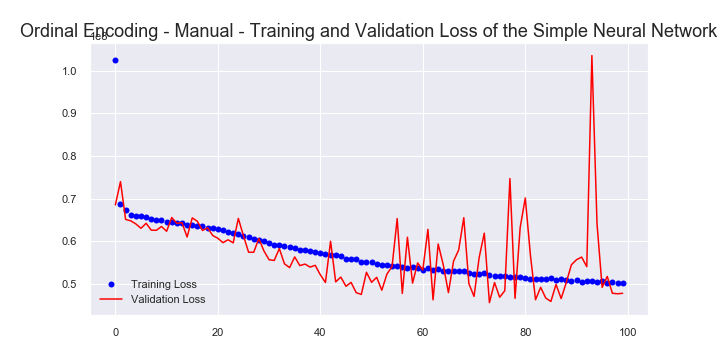

In [55]:
# Plot the training history of the model by the train and validation loss
plot_title = "Ordinal Encoding - Manual - Training and Validation Loss of the Simple Neural Network"
if 'simple_nn_ordinal_history' in globals():
    plot_nn_history(
        simple_nn_ordinal_history,
        plot_title
    )
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

x-axis: Amount of epochs, y-axis: Loss in thousand

In order to use the previously trained model and make price predictions, the Keras API offers the `predict` method. This method accepts all features in a dataframe without the `price` feature and delivers a dataframe that includes the predicted prices of the respective used cars.
This is now done for the validation dataset and the test dataset and the RMSE is calculated for both.

In [56]:
# Load the best model with manual tested hyperparameters
simple_nn_ordinal = load_best_nn('simple_nn_ordinal', True)

# Print the RMSE for the validation and test set for the loaded model
y_df_test_nn_ordinal_pred = print_rmse_val_test(
    model=simple_nn_ordinal,
    x_val=x_df_train_nn_ordinal_val,
    x_test=x_df_test_nn_ordinal,
    y_val=y_df_train_nn_ordinal_val,
    y_test=y_df_test_nn_ordinal)

Best model with the lowest MSE:  simple_nn_ordinal-manual-45571847.95216.hdf5
With RMSE:  6750.692405387761


W0831 22:39:13.045722  9072 deprecation.py:506] From C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


**Validation Set:**

Root Mean Squared Error: 6750.6924039738315


**Test Set:**

Root Mean Squared Error: 6843.64795814518


As you can see from the two RMSE values, the model is not over-fitted and the error does not differ much, so we have a valid model, which however predicts the price much too inaccurately.

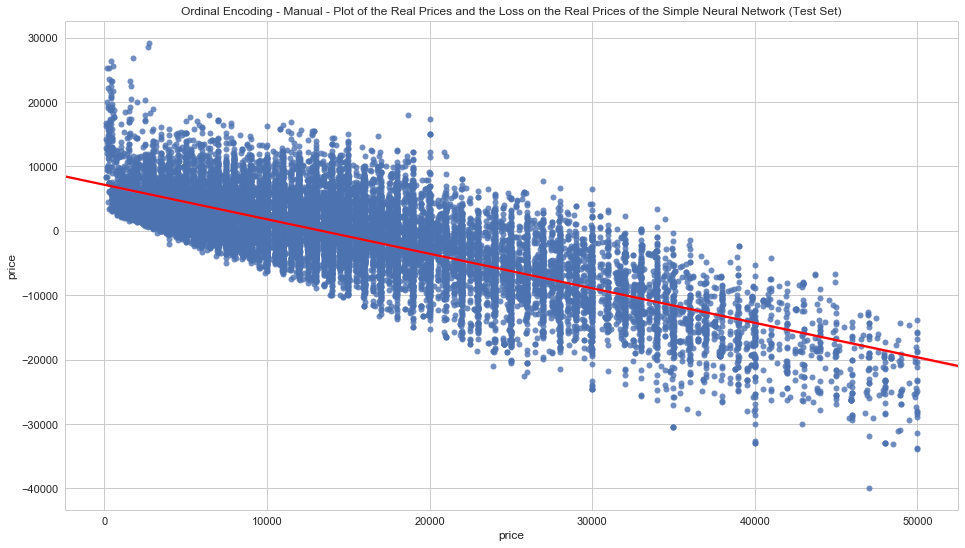

In [57]:
plot_title = 'Ordinal Encoding - Manual - Plot of the Real Prices and the Loss on the Real Prices of the Simple Neural Network (Test Set)'
if 'y_df_test_nn_ordinal_pred' in globals() and 'y_df_test_nn_ordinal' in globals():
    display_regplot_loss_prices(y_df_test_nn_ordinal_pred, y_df_test_nn_ordinal, plot_title)
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

This graph shows the extent to which the predicted price deviates from the real price.
The real price $y$ is displayed on the x-axis and the deviation from the real price $\hat{y}-y$ is displayed on the y-axis.
Moreover, it can be seen that the deviation of the estimated price from the real price the more expensive or cheaper the car will be getting bigger or lower.
The used cars in the price range of approx. 12000 to 16000 dollars are estimated very well, because at this point the average deviation is near to zero.
This may be due, for example, to the fact that some Craigslist users set used cars much too low or too high in their actual value.
Furthermore, the car models in the `make` feature are not hard selectable, but anyone can enter text there.
Possibly the data are therefore generally too unclean.

In [59]:
# Get equation of regression line
m_ordinal_manual, b_ordinal_manual = get_reg_line_equotation(y_df_test_nn_ordinal_pred, y_df_test_nn_ordinal)

**Function for the regression line (in form $f(x)=m\cdot x+b$):**

$f(x)= -0.536 \cdot x + 7145.174$

**Results of the manual hyperparameter testing:**

After some hyperparameter combinations have been tested, something has been noticed that can be used to shorten the automated testing of hyperparameter combinations and keep the combination possibilities small:
* More than 50 epochs usually make little sense, since the error does not change at all or only very slightly afterwards.
* Many layers with many neurons ensure that the model can still adapt badly to the data, because structures are learned which do not exist or are incorrect.
* Different activation functions were tested (e.g. relu, elu, softmax, softplus, tanh, linear, exponential, sigmoid). It was noticed that only active functions such as relu, softmax or softplus provide good results. It could also be recognized that only good results can be achieved if the same activation function is used in the different layers.

Since the individual hyperparameters of a neural network have been set manually, it makes sense to test all possible combinations of parameters automatically and to save the best models, because the manual setting of hyperparameters is rather a matter of luck.
If all combinations of hyperparameters are tested, it is likely that a good solution was found in the end within the given parameters.

**Note:** Runtime is round about 15 to 18 hours (Intel Xeon E3-1226 v3)

In order to save time, 10 percent of the hyperparameter configurations were tested randomly.

In [ ]:
# Define a function to search for different set of hyperparameters
def search_best_simple_nn_ordinal(x_train, y_train, x_val, y_val, params):
    
    # Define a sequential model
    model = Sequential()
    
    # Define the input layer
    model.add(Dense(params['neurons'], input_shape=(x_train.shape[1],),
                            activation=params['activation'],
                            kernel_initializer='normal'))
    
    # Define the hidden layer(s)
    model.add(Dense(params['neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer']))
    #hidden_layers(model, params, 1)

    # Define the output layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    # Compile the model
    model.compile(loss=params['losses'],
                  optimizer=RMSprop(),
                  metrics=['mean_squared_error'])
    
    # Define checkpoint name syntax
    checkpoint_name = '../Models/neural_networks/simple_nn_ordinal/simple_nn_ordinal-{val_loss:.5f}.hdf5'
    # Create checkpoint
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    # Add the checkpoint to a list to proof if the actual model is better than the models before
    callbacks_list = [checkpoint]
    
    # Start to train the model
    history = model.fit(x_train, y_train,
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=callbacks_list,
                        verbose=2)
    
    # Return the model an the training history to work with
    return history, model


# Define some parameters of the neural network
param_grid = {
    #'first_neuron':[16, 32, 64],
    #'hidden_layers':[0, 1, 2],
    'neurons': [10, 32, 64],
    'batch_size': (5, 32, 64),
    'epochs': [10, 20, 50],
    'dropout': (0, 0.15, 0.3),
    'weight_regulizer':[None],
    'emb_output_dims': [None],
    'kernel_initializer': ['uniform','normal'],
    'losses': [mse],
    'activation':[relu, softmax, softplus],
    'last_activation': [relu, softmax]}

# Run the experiment
simple_nn_ordinal_search = ta.Scan(
    x=x_df_train_nn_ordinal.to_numpy(),
    y=y_df_train_nn_ordinal.to_numpy(),
    model=search_best_simple_nn_ordinal,
    grid_downsample=0.10, # Test random 10 percent of hyperparameter combinations
    params=param_grid,
    experiment_no='1'
)

After all predefined hyperparameter combinations are tested, a good model should be identified. With the method `load_best_nn` the best model which was found during the automatic hyperparameter test will be loaded from a predefined path. After that the model can be used to make a prediction for the validation and test set. As described above the RMSE will be calculated for the validation and test set.

In [60]:
# Load the best model from saved checkpoints
simple_nn_ordinal = load_best_nn('simple_nn_ordinal')

# Print the RMSE for the validation and test set for the loaded model
y_df_test_nn_ordinal_pred = print_rmse_val_test(
    model=simple_nn_ordinal,
    x_val=x_df_train_nn_ordinal_val,
    x_test=x_df_test_nn_ordinal,
    y_val=y_df_train_nn_ordinal_val,
    y_test=y_df_test_nn_ordinal)

Best model with the lowest MSE:  simple_nn_ordinal-43458358.46687.hdf5
With RMSE:  6592.2953868034465


**Validation Set:**

Root Mean Squared Error: 6540.959368391052


**Test Set:**

Root Mean Squared Error: 6626.334859557418


The model found with the help of the automatic hyperparameter search could be mapped a few extrema better, but the position of the regression line has hardly changed in the following plot and the Root Means Squared Error was only improved from 6789 to 6573 on the Validation Set and from 6893 to 6667 on the Test Set. In contrast to the decision trees, these results are still quite bad.

In [61]:
# Print the structure of the best model
simple_nn_ordinal.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


When viewing the model structure, which of the layers is identical to the previous model (as this provided the best results), the maximum number of neurons in each layer is used, which was previously defined in the hyperparameters.
So in the future it might make sense to provide a larger number of neurons in the hyperparameter configuration.

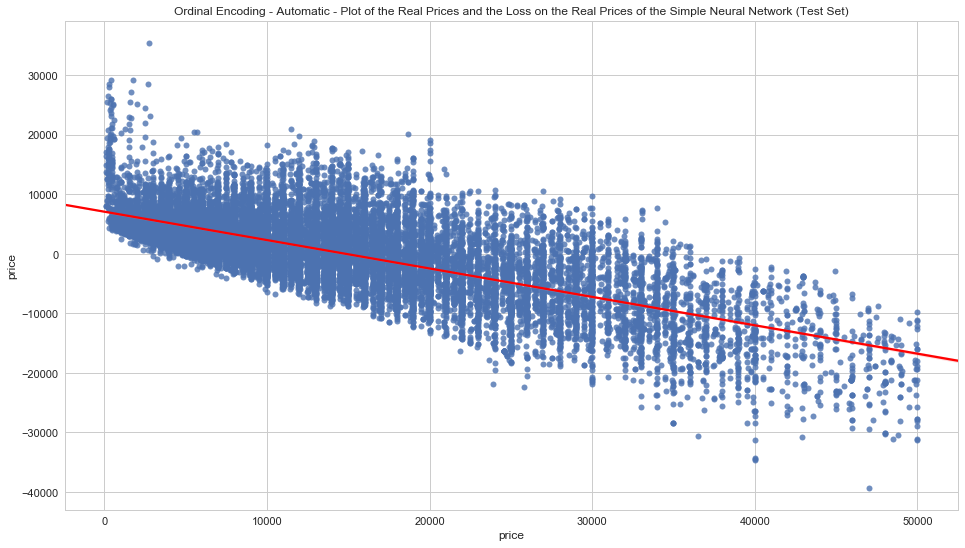

In [62]:
plot_title = 'Ordinal Encoding - Automatic - Plot of the Real Prices and the Loss on the Real Prices of the Simple Neural Network (Test Set)'
if 'y_df_test_nn_ordinal_pred' in globals() and 'y_df_test_nn_ordinal' in globals():
    display_regplot_loss_prices(y_df_test_nn_ordinal_pred, y_df_test_nn_ordinal, plot_title)
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

In [64]:
# Get equation of regression line
m_ordinal_automatic, b_ordinal_automatic = get_reg_line_equotation(y_df_test_nn_ordinal_pred, y_df_test_nn_ordinal)

**Function for the regression line (in form $f(x)=m\cdot x+b$):**

$f(x)= -0.477 \cdot x + 7080.194$

As can be seen from the equation of the regression line, it has now become somewhat flatter, as the slope has risen from -0.55 to -0.48. This is due to the fact that the regression line is now a bit flatter. However, the prices of cheap used cars are still estimated too high and the prices of more expensive used cars too low.

### Simple Sequential Neural Network (with One Hot Encoding)
After trying to train a neural network with ordinal encoded data, this step tries to do the same with the one hot encoded data and then compares it with the previous results.

The following hyperparameter configuration was tested manually:
* Activation functions: relu, softmax, softplus, tanh, linear, exponential, sigmoid, elu
* Numbers of hidden layers:
    * Numbers of dropout layers: 0, 1, 2, 3
    * Numbers of dense layers: 0, 1, 2, ..., 7, 8
* Dropout rate: 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5
* Nodes in each layer: 1, 5, 10, 20, 32, 64, 128, 256, 512

In [ ]:
# Define a sequential model
simple_nn_onehot = Sequential()

# Define the input layer
simple_nn_onehot.add(Dense(10, activation='relu', input_shape=(x_df_train_nn_onehot.shape[1],)))

# Define the hidden layers
simple_nn_onehot.add(Dense(32, activation='relu'))

# Define the output layer
simple_nn_onehot.add(Dense(1))

# Compile the model
simple_nn_onehot.compile(loss='mean_squared_error', optimizer=RMSprop(), metrics=['mean_squared_error'])

# Print a model summary
simple_nn_onehot.summary()

As before, a sequential model was created and manually adjusted in the parameters in order to obtain the best possible results.
In the next step, checkpoints are defined again to store any model that is better than the previous one.
Once defined, the previously defined model `simple_nn_onehot` can be trained to make price predictions about the test data set and evaluate the model.
As before the model runs 100 epochs to see, if more epochs makes sense and further decrease the loss.

In [ ]:
# Define checkpoint name syntax
checkpoint_name = '../Models/neural_networks/simple_nn_onehot/simple_nn_onehot-manual-{val_loss:.5f}.hdf5'
# Create checkpoint
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# Add the checkpoint to a list to proof if the actual model is better than the models before
callbacks_list = [checkpoint]

# Start to train the model
simple_nn_onehot_history = simple_nn_onehot.fit(
    x=x_df_train_nn_onehot,
    y=y_df_train_nn_onehot,
    batch_size=32,
    epochs=100,
    validation_data=(x_df_test_nn_onehot, y_df_test_nn_onehot),
    callbacks=callbacks_list,
    verbose=2
)

Now take again a look on the training history.
The history shows that further epochs would not cause a significant difference of the loss, since already from about 40 epochs the loss on the training data has changed only minimally or not at all and on the validation data starts to oscillate weakly.
So 50 epochs for the training are completely sufficient.

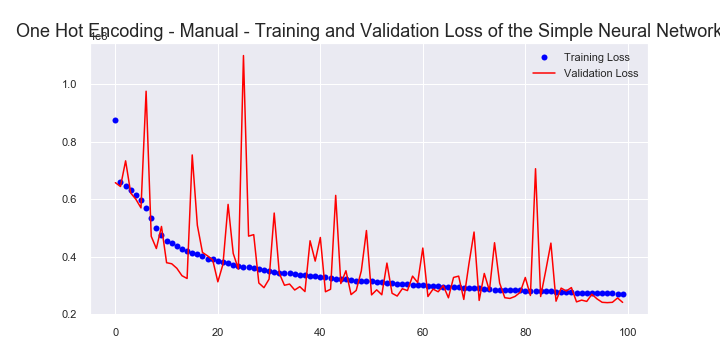

In [65]:
# Plot the training history of the model by the train and validation loss
plot_title = "One Hot Encoding - Manual - Training and Validation Loss of the Simple Neural Network"
if 'simple_nn_onehot_history' in globals():
    plot_nn_history(
        simple_nn_onehot_history,
        plot_title
    )
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

x-axis: Amount of epochs, y-axis: Loss in thousand

In this case it makes sense to train more than 50 epochs, because the Validation Loss varies a lot from the beginning, but a better result can still be found. More than 100 epochs doesn't make sense anymore, because the training loss and validation loss hardly change here.

In [66]:
# Load the best model which was trained manually
simple_nn_onehot = load_best_nn('simple_nn_onehot', True)

# Print the RMSE for the validation and test set for the loaded model
y_df_test_nn_onehot_pred = print_rmse_val_test(
    model=simple_nn_onehot,
    x_val=x_df_train_nn_onehot_val,
    x_test=x_df_test_nn_onehot,
    y_val=y_df_train_nn_onehot_val,
    y_test=y_df_test_nn_onehot)

Best model with the lowest MSE:  simple_nn_onehot-manual-24096004.20236.hdf5
With RMSE:  4908.768094171897


**Validation Set:**

Root Mean Squared Error: 4844.6959524563335


**Test Set:**

Root Mean Squared Error: 4908.7680833288805


At this point it can be seen that One Hot Encoding is very useful for this data set, since the RMSE has dropped by about 1500, if one compares this model with the model that was trained on the data processed with ordinal encoding.
In the manual training, the best model delivered an RMSE on the Validation Set of 6789 and an RMSE on the Test Set of 6893.
In contrast, with the one hot encoded data, we get an RMSE of 4844 on the Validations Set and an RMSE of 4908 on the Test Set.

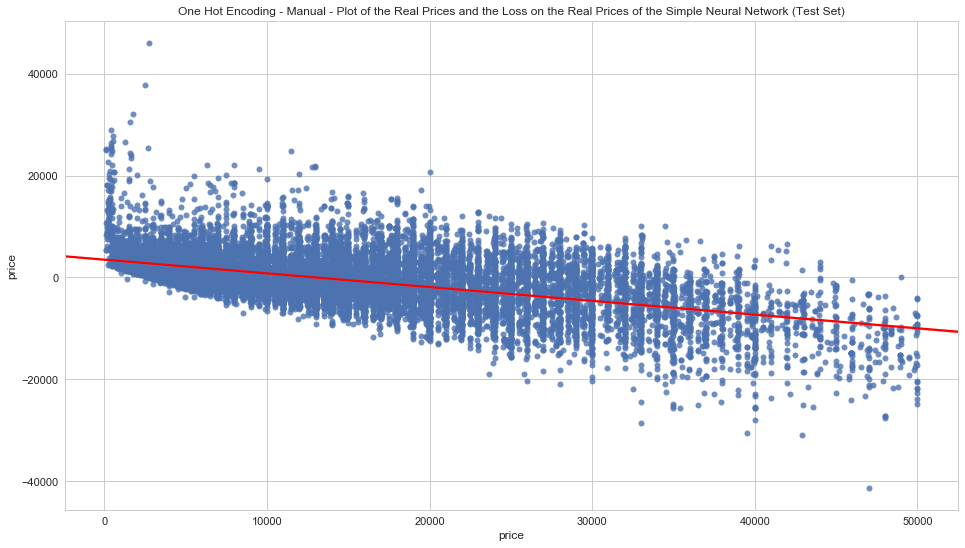

In [67]:
plot_title = 'One Hot Encoding - Manual - Plot of the Real Prices and the Loss on the Real Prices of the Simple Neural Network (Test Set)'
if 'y_df_test_nn_onehot_pred' in globals() and 'y_df_test_nn_onehot' in globals():
    display_regplot_loss_prices(y_df_test_nn_onehot_pred, y_df_test_nn_onehot, plot_title)
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

In [69]:
# Get equation of regression line
m_onehot_manual, b_onehot_manual = get_reg_line_equotation(y_df_test_nn_onehot_pred, y_df_test_nn_onehot)

**Function for the regression line (in form $f(x)=m\cdot x+b$):**

$f(x)= -0.269 \cdot x + 3490.452$

This graph also shows the extent to which the forecast price deviates from the real price.
The real price $y$ is displayed on the x-axis and the deviation from the real price $\hat{y}-y$ is displayed on the y-axis.
This shows a clear improvement with the gradient from -0,482 to -0,269, since the regression line is now closer to 0, which means that on average the estimation error has decreased.
Particularly in the case of high-priced used cars, it can be seen that the model estimates itself "only" by about 10000 dollars on average.
However, there is still the problem that very cheap used cars are too expensive and very expensive used cars are too cheap.

**Results of the manual hyperparameter testing:**

Now that some hyper parameter combinations have been tested, it has become apparent that fewer dense or dropout layers provide better results in this case.
It also makes sense to train more than 50 epochs, because even then better models can be achieved.
At this point, these combinations have changed further to the model trained with ordinally encoded data.
Another thing that was noticed during the testing was that a dropout worsened the results rather than improved them.
For this reason the dropout will maybe be set to zero in the hyper parameters.

Since the individual hyperparameters of a neural network have been set manually, test again different combinations of hyperparameters automatically.

**Note:** Runtime is round about 15 to 18 hours (Intel Xeon E3-1226 v3)

In order to save time, 20 percent of the hyperparameter configurations were tested randomly.

In [ ]:
# Define a function to search for different set of hyperparameters
def search_best_simple_nn_onehot(x_train, y_train, x_val, y_val, params):
    
    # Define a sequential model
    model = Sequential()
    
    # Define the input layer
    model.add(Dense(params['neurons'], input_shape=(x_train.shape[1],),
                            activation=params['activation'],
                            kernel_initializer='normal'))
    
    # Define the hidden layer(s)
    model.add(Dense(params['neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer']))
    #hidden_layers(model, params, 1)

    # Define the output layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    # Compile the model
    model.compile(loss=params['losses'],
                  optimizer=RMSprop(),
                  metrics=['mean_squared_error'])
    
    # Define checkpoint name syntax
    checkpoint_name = '../Models/neural_networks/simple_nn_onehot/simple_nn_onehot-{val_loss:.5f}.hdf5'
    # Create checkpoint
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    # Add the checkpoint to a list to proof if the actual model is better than the models before
    callbacks_list = [checkpoint]
    
    # Start to train the model
    history = model.fit(x_train, y_train,
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=callbacks_list,
                        verbose=2)
    
    # Return the model an the training history to work with
    return history, model


# Define some parameters of the nerual network
param_grid = {
    #'first_neuron':[16, 32, 64],
    #'hidden_layers':[0, 1, 2],
    'neurons': [10, 32, 64],
    'batch_size': (5, 32, 64),
    'epochs': [100],
    #'dropout': (0, 0.15, 0.3),
    'weight_regulizer':[None],
    'emb_output_dims': [None],
    'kernel_initializer': ['uniform','normal'],
    'losses': [mse],
    'activation':[relu, softmax, softplus],
    'last_activation': [relu, softmax]}

# Run the experiment
simple_nn_onehot_search = ta.Scan(
    x=x_df_train_nn_onehot.to_numpy(),
    y=y_df_train_nn_onehot.to_numpy(),
    model=search_best_simple_nn_onehot,
    grid_downsample=0.20, # Test random 20 percent of hyperparameter combinations
    params=param_grid,
    experiment_no='2'
)

Now 20 percent of the possible hyper parameter combinations have been tested and the best model is loaded with the method `load_best_nn`.

In [70]:
# Load the best model with automatically tested hyperparameter
simple_nn_onehot = load_best_nn('simple_nn_onehot')

# Print the RMSE for the validation and test set for the loaded model
y_df_test_nn_onehot_pred = print_rmse_val_test(
    model=simple_nn_onehot,
    x_val=x_df_train_nn_onehot_val,
    x_test=x_df_test_nn_onehot,
    y_val=y_df_train_nn_onehot_val,
    y_test=y_df_test_nn_onehot)

Best model with the lowest MSE:  simple_nn_onehot-25252010.77756.hdf5
With RMSE:  5025.13788642262


W0831 22:39:57.198060  9072 deprecation.py:506] From C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


**Validation Set:**

Root Mean Squared Error: 4901.946999321554


**Test Set:**

Root Mean Squared Error: 4960.902236196741


In this case it is noticeable that the hyper parameter tuning did not do much good, because the RMSE on the Train Set as well as on the Test Set deteriorated again by about 50. So a better model could be found by random testing. However, it should be noted that only 20 percent of all hyper parameter combinations were tested. So it can be that only bad combinations were randomly selected.

In [71]:
# Print the structure of the best model
simple_nn_onehot.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                17440     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 18,529
Trainable params: 18,529
Non-trainable params: 0
_________________________________________________________________


The parameters of the best model also differ slightly from those before, then the Input Dense Layer contains 32 neurons.

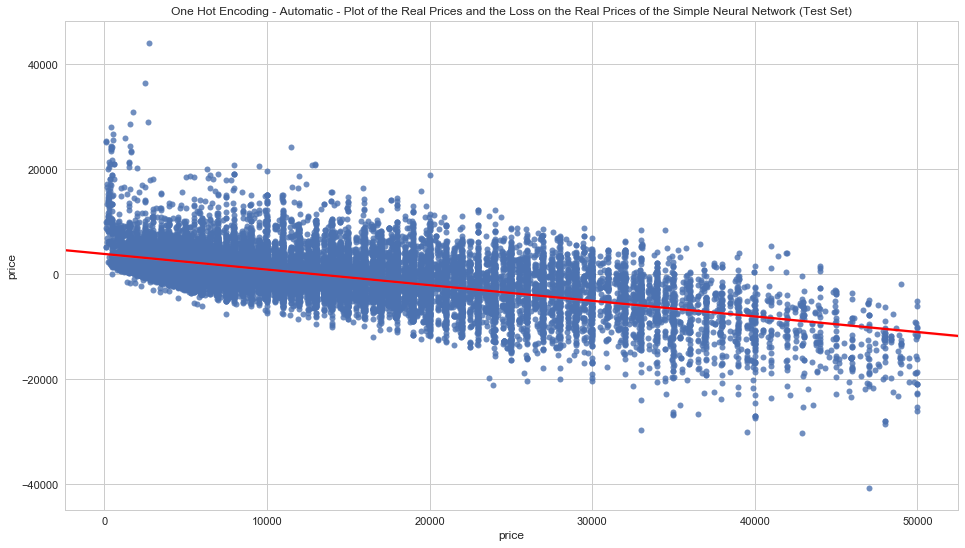

In [72]:
plot_title = 'One Hot Encoding - Automatic - Plot of the Real Prices and the Loss on the Real Prices of the Simple Neural Network (Test Set)'
if 'y_df_test_nn_onehot_pred' in globals() and 'y_df_test_nn_onehot' in globals():
    display_regplot_loss_prices(y_df_test_nn_onehot_pred, y_df_test_nn_onehot, plot_title)
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

In [74]:
# Get equation of regression line
m_onehot_autmatic, b_onehot_automatic = get_reg_line_equotation(y_df_test_nn_onehot_pred, y_df_test_nn_onehot)

**Function for the regression line (in form $f(x)=m\cdot x+b$):**

$f(x)= -0.297 \cdot x + 3859.215$

As already described above, the regression line, which represents the deviation from the real price, also shows that the model has only improved to a limited extent. This is because cheap cars are estimated even better, since the prices for cheap used cars are estimated on average only 3490 dollars too high. However, the slope is more negative, which means that expensive used cars are less well represented by the model.

### Simple Sequential Neural Network (with Binary Encoding)
Finally, we try to improve the previous model with the help of binary encoding.
In the following a sequential model will be defined.

In [ ]:
# Define a sequential model
simple_nn_binary = Sequential()

# Define the input layer
simple_nn_binary.add(Dense(10, input_shape=(x_df_train_nn_binary.shape[1],), kernel_initializer='normal', activation='relu'))

# Define the hidden layers
simple_nn_binary.add(Dense(32, kernel_initializer='normal', activation='relu'))

# Define the output layer
simple_nn_binary.add(Dense(1, kernel_initializer='normal', activation='relu'))

# Compile the model
simple_nn_binary.compile(loss='mean_squared_error', optimizer=RMSprop(), metrics=['mean_squared_error'])

# Print a model summary
simple_nn_binary.summary()

In [ ]:
# Define checkpoint name syntax
checkpoint_name = '../Models/neural_networks/simple_nn_binary/simple_nn_binary-manual-{val_loss:.5f}.hdf5'
# Create checkpoint
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# Add the checkpoint to a list to proof if the actual model is better than the models before
callbacks_list = [checkpoint]

# Start to train the model
simple_nn_binary_history = simple_nn_binary.fit(
    x_df_train_nn_binary_train, y_df_train_nn_binary_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_df_train_nn_binary_val, y_df_train_nn_binary_val),
    callbacks=callbacks_list,
    verbose=2
)

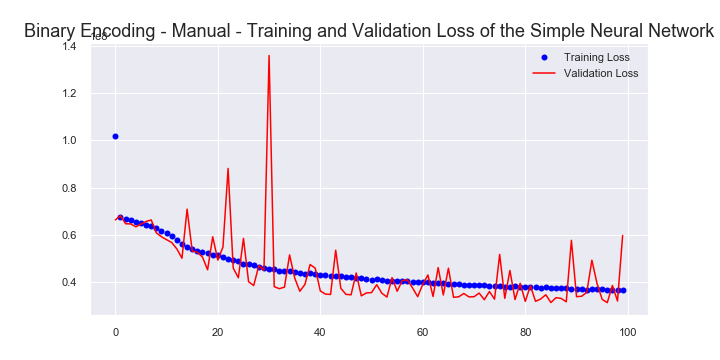

In [75]:
# Plot the training history of the model by the train and validation loss
plot_title = "Binary Encoding - Manual - Training and Validation Loss of the Simple Neural Network"
if 'simple_nn_binary_history' in globals():
    plot_nn_history(
        simple_nn_binary_history,
        plot_title
    )
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

x-axis: Amount of epochs, y-axis: Loss in thousand

This history also shows that more than 50 epochs do not further significantly improve the loss, since the validation loss increases and decreases relatively evenly from 50 epochs onwards.

In [76]:
simple_nn_binary = load_best_nn('simple_nn_binary', True)

# Print the RMSE for the validation and test set for the loaded model
y_df_test_nn_binary_pred = print_rmse_val_test(
    model=simple_nn_binary,
    x_val=x_df_train_nn_binary_val,
    x_test=x_df_test_nn_binary,
    y_val=y_df_train_nn_binary_val,
    y_test=y_df_test_nn_binary)

Best model with the lowest MSE:  simple_nn_binary-manual-31400326.05190.hdf5
With RMSE:  5603.59938360158


**Validation Set:**

Root Mean Squared Error: 5603.5993735285565


**Test Set:**

Root Mean Squared Error: 5627.459366179724


The RMSE on the Validation and Test set shows that the binary encoding has made the model worse again. The RMSE has been reduced to about 5200 using one hot encoding.

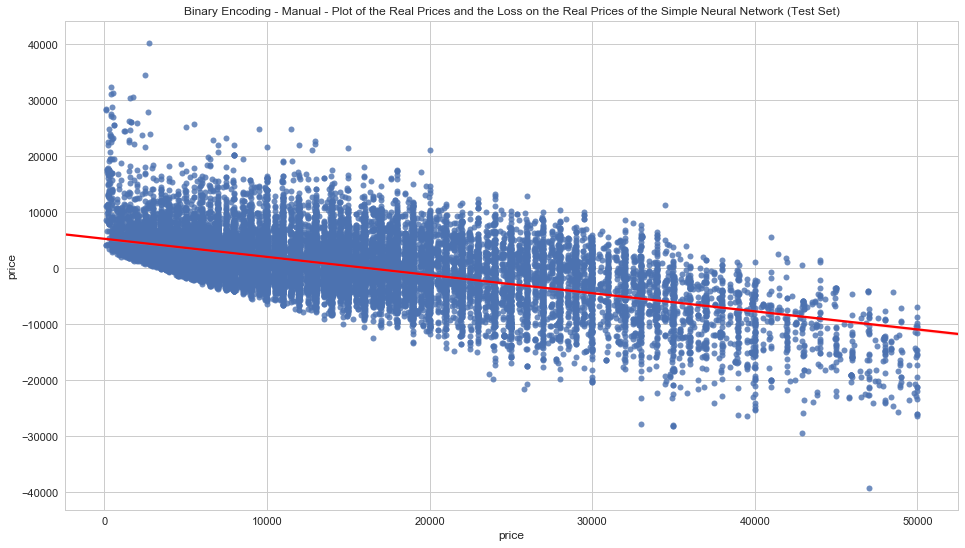

In [77]:
plot_title = 'Binary Encoding - Manual - Plot of the Real Prices and the Loss on the Real Prices of the Simple Neural Network (Test Set)'
if 'y_df_test_nn_binary_pred' in globals() and 'y_df_test_nn_binary' in globals():
    display_regplot_loss_prices(y_df_test_nn_binary_pred, y_df_test_nn_binary, plot_title)
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

In [78]:
# Get equation of regression line
m_binary_manual, b_binary_manual = get_reg_line_equotation(y_df_test_nn_binary_pred, y_df_test_nn_binary)

**Function for the regression line (in form $f(x)=m\cdot x+b$):**

$f(x)= -0.324 \cdot x + 5229.627$

It is interesting to note that the climb has become more negative again than with the one hot encoding, but the regression line starts at point 0 below the regression level of the one hot encoding.
This means that used cars with a low price can be estimated better than with the other two types of encoding.
However, it should be noted that due to the smaller slope and the shift on the y-axis, used cars at a high price can be estimated less accurately than with one hot encoding.

**Results of the manual hyperparameter testing:**

After some hyperparameter combinations have been tested, something has been noticed that can be used to shorten the automated testing of hyperparameter combinations and keep the combination possibilities small:
* Same as results as the ordinal encoded model
* Many neurons make no sense because the RMSE will become a lot higher than with low number of neurons
* In contrast to the one hot encoded model, 50 epochs are sufficient to find a "good" model

The next step is to try again to find a better model using the automated hyperparameter testing.

**Note:** Runtime is round about 15 to 18 hours (Intel Xeon E3-1226 v3)

In order to save time, 10 percent of the hyperparameter configurations were tested randomly.

In [ ]:
# First make sure to input data and params into function
def search_best_simple_nn_binary(x_train, y_train, x_val, y_val, params):
    # Define a sequential model
    model = Sequential()
    
    # Define the input layer
    model.add(Dense(params['neurons'], input_shape=(x_train.shape[1],),
                            activation=params['activation'],
                            kernel_initializer='normal'))
    
    # Define the hidden layer(s)
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer']))
    #hidden_layers(model, params, 1)

    # Define the output layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    # Compile the model
    model.compile(loss=params['losses'],
                  optimizer=RMSprop(),
                  metrics=['mean_squared_error'])
    
    # Define checkpoint name syntax
    checkpoint_name = '../Models/neural_networks/simple_nn_binary/simple_nn_binary-{val_loss:.5f}.hdf5'
    # Create checkpoint
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    # Add the checkpoint to a list to proof if the actual model is better than the models before
    callbacks_list = [checkpoint]
    
    history = model.fit(x_train, y_train,
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=callbacks_list,
                        verbose=2)
    
    # Return the model an the training history to work with
    return history, model


# Define some parameters of the nerual network
param_grid = {
    #'first_neuron':[16, 32, 64],
    #'hidden_layers':[0, 1, 2],
    'neurons': [10, 32, 64],
    'batch_size': (5, 32, 64),
    'epochs': [10, 20, 50],
    'dropout': (0, 0.15, 0.3),
    'weight_regulizer':[None],
    'emb_output_dims': [None],
    'kernel_initializer': ['uniform','normal'],
    'losses': [mse],
    'activation':[relu, softmax, softplus],
    'last_activation': [relu, softmax]}

# Run the experiment
simple_nn_binary_search = ta.Scan(
    x=x_df_train_nn_binary.to_numpy(),
    y=y_df_train_nn_binary.to_numpy(),
    model=search_best_simple_nn_binary,
    grid_downsample=0.10, # Test random 10 percent of hyperparameter combinations
    params=param_grid,
    experiment_no='3'
)

In [79]:
# Load the best model with automatically tested hyperparameter configuration
simple_nn_binary = load_best_nn('simple_nn_binary')

# Print the RMSE for the validation and test set for the loaded model
y_df_test_nn_binary_pred = print_rmse_val_test(
    model=simple_nn_binary,
    x_val=x_df_train_nn_binary_val,
    x_test=x_df_test_nn_binary,
    y_val=y_df_train_nn_binary_val,
    y_test=y_df_test_nn_binary)

Best model with the lowest MSE:  simple_nn_binary-31624594.12819.hdf5
With RMSE:  5623.574853079667


**Validation Set:**

Root Mean Squared Error: 5583.056626944976


**Test Set:**

Root Mean Squared Error: 5634.082546806177


At this point it is noticeable that the hyperparameters of the first neural network, which was trained with binary encoded data, were already relatively well chosen, since the randomly tested hyperparameters could not achieve a better result.
It should be noted, however, that only 3 percent of the possible hyperparameter configurations were tested.

It should only be noted that the model on the Validation Set has become better, but on the Test Set somewhat worse than the model, with manually tested parameters.

In [80]:
# Print the structure of the best model
simple_nn_binary.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 11,533
Trainable params: 11,533
Non-trainable params: 0
__________________________________________________

The model found by the hyper parameter Tuning also differs more from the manually defined model because it has more neurons and more dense layers. However, as mentioned before, this does not necessarily lead to improved results.

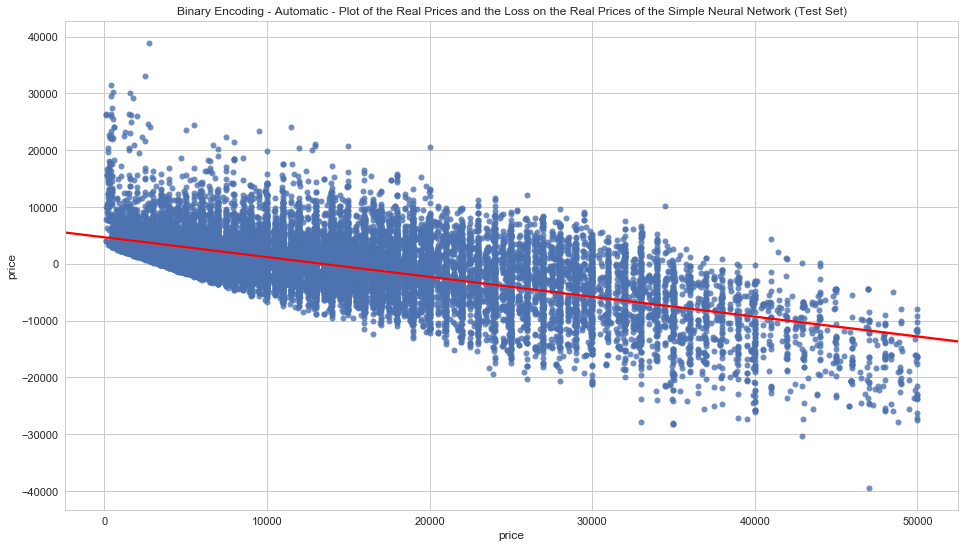

In [81]:
plot_title = 'Binary Encoding - Automatic - Plot of the Real Prices and the Loss on the Real Prices of the Simple Neural Network (Test Set)'
if 'y_df_test_nn_binary_pred' in globals() and 'y_df_test_nn_binary' in globals():
    display_regplot_loss_prices(y_df_test_nn_binary_pred, y_df_test_nn_binary, plot_title)
else:
    display(Image(filename='./img/{}.png'.format(plot_title)))

In [83]:
# Get equation of regression line
m_binary_automatic, b_binary_automatic = get_reg_line_equotation(y_df_test_nn_binary_pred, y_df_test_nn_binary)

**Function for the regression line (in form $f(x)=m\cdot x+b$):**

$f(x)= -0.349 \cdot x + 4662.615$

However, it can be seen that the slope of the regression line could not be smoothed further, but the straight line at lower real prices on the y-axis has been shifted in the direction of 0, from which it can be concluded that the prices of low-priced used cars are predicted better than before. However, as we wrote before, expensive used cars are estimated even worse than in the models before.

However, the results are still significantly worse than could be achieved with the One Hot Encoding.

## Price Prediction with Recurrent Neural Network / Long Short-Term Memory (LSTM) Neural Network
The Recurrent Neural Networks approach has the ability to influence the final decision through what has been learned in the past.
Like other types of neural networks, Recurrent Neural Networks can take one or more input vectors and generate one or more output vectors.
The output is affected not only by weights applied to the inputs like a normal neural network, but also by a state vector that represents the context based on previous inputs/outputs.
Thus, the same input can generate a different output depending on the previous inputs in the series.
[(Recurrent Neural Networks and LSTMs)](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce)

<div style="text-align:center;">
<img src="./img/structure_recurrent_neural_network.png" alt="Example Structure of a Recurrent Neural Networks" width="500" height="600"/>
<center>Source:  <a href="https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce">Recurrent Neural Networks and LSTMs</a>
</center>
</div>

In the above example of a recurrent neural network, different inputs $x_1,x_2,x_3,\ldots$ exist, which are weighted by an edge weight $W_x$ and get to the activation function $h_1,h_2,h_3,\ldots$ of the neurons in the next layer.
Furthermore, a function $h_0$ creates an input, which is weighted with $W_h$ and passed to the activation function $h_1$ in the first neuron.
The activation function $h_1$ now uses the two incoming weighted values and returns an output $y_1$ weighted with $W_y$ and passes the result on to the activation function $h_2$ for the following neuron.
This process continues until all neurons in a layer have calculated an output.
[(Recurrent Neural Networks and LSTMs)](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce)

But this approach focuses on problems where a prediction should be made about something that is based and correlated to previous sequences or data.
However, in the case of used car pricing, this approach does not help because the prices of used cars are not sequential and do not correlate in a sequential order.

The same is true for the Long Short-Term Memory Neural Networks, which are an extension of the "normal" Recurrent Neural Network and are particularly suitable for correlating data over longer sequences, which is not the case here, however, and this approach will not deliver promising results either.
It only introduces some changes of how computation the outputs and hidden state using the input dataset.
Note that many other types of recurrent neural networks exist and only the best known are explained here.
[(Recurrent Neural Networks and LSTMs)](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce)

## Price Prediction with Convolutional Neural Network
Convolutional Neural Networks have the ability to learn positions and scales of data structures, which is especially important for image processing.
This type of network is particularly suitable for data that is spatially related, which makes this approach relatively unattractive for the problem considered in this notebook, as predicting prices for used cars is difficult to determine by position and scaling of the data.
Furthermore, Kaggle's given data set is not "spatial", so the "good" property of this approach cannot be used.
For this reason, convolutional Neural Networks are not considered more closely for the given problem.

## Results Neural Networks
To close this chapter, the results of all different models are listed at the beginning.

<table style="width:100%">
  <colgroup>
    <col width="300">
    <col width="100">
    <col width="100">
  </colgroup>
  <tr>
    <th>Model</th>
    <th>Validation set RMSE</th>
    <th>Test set RMSE</th>
  </tr>
  <tr>
    <td>Sequential Neural Network (with Ordinal Encoding and Manual Parameter Testing)</td>
    <td align="center">6750.692</td>
    <td align="center">6843.647</td>
  </tr>
  <tr>
    <td>Sequential Neural Network (with Ordinal Encoding and Automatic Parameter Testing)</td>
    <td align="center">6540.959</td>
    <td align="center">6626.334</td>
  </tr>
  <tr>
    <td>Sequential Neural Network (with One Hot Encoding and Manual Parameter Testing)</td>
    <td align="center">4844.695</td>
    <td align="center">4908.768</td>
  </tr>
  <tr>
    <td>Sequential Neural Network (with One Hot Encoding and Automatic Parameter Testing)</td>
    <td align="center">4901.946</td>
    <td align="center">4960.902</td>
  </tr>
  <tr>
    <td>Sequential Neural Network (with Binary Encoding and Manual Parameter Testing)</td>
    <td align="center">5603.599</td>
    <td align="center">5627.459</td>
  </tr>
  <tr>
    <td>Sequential Neural Network (with Binary Encoding and Automatic Parameter Testing)</td>
    <td align="center">5583.056</td>
    <td align="center">5634.082</td>
  </tr>
</table>

\* RMSE = Root Mean Squared Error

When looking at the results, it becomes immediately clear that neural networks are not so well suited for this data set.
Between the approaches of neural networks, the error could be partially reduced again, but the results were not as good as with the decision trees.
The RMSE is sometimes more than twice as high as the tree-based methods, so that it is not helpful to predict the exact price of a used car at about 5500 dollars.

However, the best result was achieved using One Hot Encoding. Furthermore, it sometimes makes sense to test several combinations through the Hyperparameter Tuning in order to improve the model. Here, however, it should be weighed up to what extent it is worth the computational effort, since significant model improvements have not been achieved with the help of hyperparameter tuning. For example, the One Hot Encoding model was even made worse by the Hyperparameter Tuning. Moreover, even in the best case the RMSE could only be reduced by about 200 dollars, which of course is not a groundbreaking new result.

# Picture Processing

In [84]:
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model


from tqdm import tqdm

from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import os
import cv2

**Note:** All outputs were documented here in the tables. Therefore they are not to be seen here in the notebook. This has the reason that texts are generated for output and a new execution of the code takes too long. Generated models can be found in the order `.\Models\images_nn`.

## Preprocessing
### Scaling

As the pictures are available in about 600x450p, using the full resolution would be extremely hardware intense. To minimize the computing effort, the images should be reduced in size, which can be done with a variety of algortihms, the opencv library provides. Below the INTER_LINEAR (standard), INTER_AREA and INTER_CUBIC variants are displayed with a corresponding picture. As it is visible, the INTER_LINEAR and INTER_CUBIC approach tend to create a rather pixelated image, whereas the INTER_AREA creates a smooth and more lifelike image. As it appears to be the best algroithm, it shall be used as the standard for scaling operation within this notebook.

<div style="text-align:center;">
<img src="./img/Image_scaling.png" alt="Image scaling example" width="80%" align="center"/>
<center>Example of the different scaling approaches
</center>
</div>

### Canny Edge Detection
As it might be a sensible option to apply a edge detection, we define a further method, which takes the images and applies the filter. To illustrate the difference an example is attached below:

<div style="text-align:center;">
<img src="./img/canny.png" alt="Image scaling example" width="80%" align="center"/>
<center>Example of the canny edge detection
</center>
</div>

## Loading and adjusting the images
To work with the images, we have do read them in first. We achieve this be defining a customizable method, which is capable of scaling, grayscaling and applying the edge-detection on the fly, which is more memory efficient than doing it one after another. As described above, the INTER_AREA scaling option is used for scaling and to grayscale to pictures. Furthermore the standard values for the edge-detection are used.

In [85]:
def load_images(df, inputPath, amount, resX, resY, grayscaled=True, CANNY=False):
    """
    loads the images and adjusts them on the fly. This method uses the notebook-version 
    of tqdm to visualize the progress, which might lead to lead to a wrong progress-bar within 
    Jupyter Lab. 

    Parameters
    ----------
    df : pandas.dataframe
        Whole dataset of craigslist inserates.
    inputPath : String
        The path, where the images are stored
    amount: int
        The amount of pictures which were loaded beforehand
    """
    
    # initialize our images array
    images = []
    
    if(grayscaled == True):
        gray = 0
    else:
        gray = 1
        
    # loop over the indexes of the cars  
    for index in tqdm(range(0,amount)):
        car_id = df.iloc[index]["car_id"]
        if(car_id <= amount):
            path = inputPath + "{}.jpg".format(car_id)
            if(os.path.exists(path)):
                image = cv2.imread(path, gray)
                image = cv2.resize(image, (resX, resY), interpolation = cv2.INTER_AREA)
                if CANNY==True:
                    image = cv2.Canny(image,100,500)
                images.append(image)
                
    del car_id, path, image
        
    return np.array(images)

We now start loading the images and set the corresponding variables. Which filters are applied to the images can easily be adapted, but the default is a simple grayscaled image with the resolution of 80x60. Lastly these variables will have further effect on the later defined neural networks, as they will be automically adapted to process grayscaled or colored pictures.

In [86]:
# In this case we want to read in the whole dataset, which may take some time depending on your machine.
# Systems with less than 16GB RAM might run into issues later on or at least, if colors are used.
# Increasing the resolution heavily increases the memory consumption as well as the computational intensity
amount = int(df.shape[0])
resX = 80
resY = 60
grayscaled = False
canny = False
image_path = "../Data/car_images/" # original images
# image_path = "../Data/images_cut/"  # cropped images

images = load_images(df,
                     image_path,
                     amount,
                     resX, resY,
                     grayscaled,
                     canny)

100%|██████████████████████████████████████████████████████████████████████████| 110787/110787 [19:37<00:00, 94.06it/s]


To show, that the filter applied, we plot a few of the pictures:

<function matplotlib.pyplot.show(*args, **kw)>

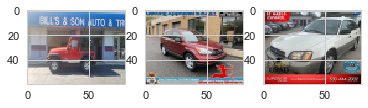

In [87]:
if grayscaled:
    plt.subplot(1,3,1),plt.imshow(images[0], cmap='gray')
    plt.subplot(1,3,2),plt.imshow(images[int(images.shape[0]/2)], cmap='gray')
    plt.subplot(1,3,3),plt.imshow(images[images.shape[0]-1], cmap='gray')
else:
    plt.subplot(1,3,1),plt.imshow(images[0][...,::-1])
    plt.subplot(1,3,2),plt.imshow(images[int(images.shape[0]/2)][...,::-1])
    plt.subplot(1,3,3),plt.imshow(images[images.shape[0]-1][...,::-1])
plt.show

To assure, that the dataframe and image array contain the same amount of entries, we remove all the entries, no corresponding image was found and/or loaded.

In [108]:
def adjust_df(df, inputPath, amount):
    """
    Removes the images from the dataframe, which were not read in and/or are not available

    Parameters
    ----------
    df : pandas.dataframe
        Whole dataset of craigslist inserates.
    inputPath : String
        The path, where the images are stored
    amount: int
        The amount of pictures which were loaded beforehand
    """
    df_temp = df
    index_list = []
 
    # loop over the indexes of the cars
    for i in df.car_id.values:
        path = inputPath + "{}.jpg".format(i)
        if(not os.path.exists(path) or i>amount):
            index_list.append(i-1)
    df_temp = df_temp.drop(df_temp.index[index_list])
    
    del index_list, path
        
    return df_temp

In [ ]:
df = adjust_df(df, image_path, amount)

We now put the data into a shape, the neural networks are made to work with. First we normalize the images, which means, we form the color values, which range from 0-255 to 0-1. On that way, prevent any convergence issues. Additionally in case we use grayscaled images, we have to flatten them. Colored images don't require this treatment as they provide an additional dimension for the three colors.

Finally we apply the one-hot encoding method to the categorical output-variable, which is the most common practice.

In [ ]:
#normalize the images to prevent convergence issues
images = images / 255.0
if(grayscaled == True):
    images = images.reshape(int(images.shape[0]),
                            int(images.shape[1]),
                            int(images.shape[2]),
                            1)
    
# Use one-hot encoding for the price categories
df = utils.to_categorical(df["priceCategory"])

Within the last step before we can use the neural networks, we split the data into a train- and testset. This step causes a temporarily peak in memory consumption, which might lead to issues with less powerful machines.

In [ ]:
(trainY, testY, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

#cleaning up the memory to prevent memory overflow
del images, df

In [ ]:
num_classes=len(trainY[0])
print("Classes in the trainset: {}".format(num_classes))
print("Classes in the testset: {}".format(len(testY[0])))

## Neural Networks for image data
We now start to develop a neural network to predict the value of the car by just using one picture as an input. An obvious approach would be to predict a precise value directly by applying some regression technique. However it is also a sensible option to create price categories like 0\\$ to 4999\\$ and 5000\\$ to 9999\\$ as it is more common to tackle some kind of classification problem on images, it could be a good starting point here. In our case we will apply price steps of 2000\\$.<br>

We will also use keras for these neural networks (like with the tabular data), however we will use the GPU for this purpose. It's a little special in our case as we don't use a Nvidia GPU, but an AMD GPU (an AMD RX 590). This is possible thanks to ROCm program initiated by AMD [(AMD ROCm)](https://github.com/RadeonOpenCompute/ROCm). Due to implementation, Nvidia GPUs and ordinary CPUs might lead to slightly different results than the AMD hardware. Short tests with an Intel CPU vs an AMD CPU vs. an AMD GPU led to the same results, but there is no certainty in that.

We begin with a net similiar to the net, which was used in the lecture to classify variants of clothing. It consists of two convolutional layers, two dense layers and two dropout layers. To connect the convolutional block with the dense block, a flatten layer was put inbetween.
Convolutional layers are an integral part of the image detection with neural networks. They basically scan the image for features by looking at only parts of the image. Similiar to scanning a picture with magnifying glass.

<div style="text-align:center;">
<img src="./img/keras_conv2d_padding.gif" alt="Behaviour of a convulational layer" width="80%"/>
<center>Source:  <a href="https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/">Behaviour of a convulational layer</a>
</center>
</div>

In [ ]:
# Deep Learning Model

# simple convolutional model 

def simple_conv_model(resX, resY, grayscaled, num_classes):
    dimensions = 0
    if(grayscaled):
        dimensions = 1
    else:
        dimensions = 3
    
    input_layer=layers.Input(shape=(resY,resX,dimensions), name="input_layer")

    model=layers.Conv2D(filters=16, kernel_size=5, activation="relu", padding='valid', name="first_block_conv", strides=(1,1)) (input_layer)
    model=layers.MaxPooling2D((2,2), name="first_block_pooling") (model)
    model=layers.BatchNormalization(name="first_block_bn") (model)
    
    model=layers.Conv2D(filters=16, kernel_size=5, activation="relu", padding='valid', name="second_block_conv", strides=(3,3)) (model)

    # Add Flatten Layer 
    model=layers.Flatten()(model)

    model=layers.Dense(128, activation="relu", name="dense_1") (model)
    model=layers.Dropout(0.5, name="drop_out_dense_1") (model)
    model=layers.Dense(32, activation="relu", name="dense_2") (model)

    output=layers.Dense(num_classes, activation="softmax", name="output_layer") (model)

    cnn_model=models.Model(input_layer, output)
    cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc", "categorical_accuracy"])

    print(cnn_model.summary())
    
    return cnn_model

In [ ]:
# We will generally use 50 epochs as well as a batch size of 32
# If the model looks promising, simply train a further 50 epochs (or more)
epochs = 50
batch  = 32

In [ ]:
lecture_model=simple_conv_model(resX, resY, grayscaled, num_classes)

In [ ]:
history1 = lecture_model.fit(trainImagesX, trainY,
                             epochs=epochs,
                             batch_size=batch,
                             verbose=1)

In [ ]:
print("The untouched lecture model")
print("Results from the training set:")
print(lecture_model.evaluate(trainImagesX, trainY, verbose=2))
print("Results from the test set:")
print(lecture_model.evaluate(testImagesX, testY, verbose=2))

## Results of the first net with different inputs

Resolution: 80x60<br>
pricestep-width: 2000<br>

 Model                    | Epochs | BatchSize | InputAmount(Split_size) | accuracy_train | accuracy_test | canny | color
-----------------------------|--------|-----------|-------------------------|----------------|---------------|-------|------
 lecture_model               | 50     | 32        | whole Set (0.25)        | 57.07%         | 34.59%        | no    | no
 lecture_model               | 50     | 32        | whole Set (0.25)        | 43.32%         | 27.69%        | yes   | no
 lecture_model               | 50     | 32        | whole Set* 0.75 (0.25)  | 48.97%         | 44.32%        | no    | yes




As you can see, this model isn't an approbiate solution for our problem. Images with profiled edges are not well suited for this model as the accuracy on both sets is rather low. Simple grayscaled images don't perform much better as they tend to overfit. Only the original colored images perform equally well on both sets. However there is still much room to improve. Thus for we try to alter the used model.

In the block of the convolutional layers we increase the amount of filters, change the first activation method to `sigmoid` and adapt the kernel size, so that it matches an image with the ratio of 4:3. Additionally a dropout layer is put between the flatten and first dense layer and the general dropout rate was decreased to 0.3. At last the amount of nodes in the dense layers were increased.

In [ ]:
# Deep Learning Model

# adjusted convolutional model v1

def adjusted_conv_model_v1(resX, resY, grayscaled, num_classes):
    dimensions = 0
    if(grayscaled):
        dimensions = 1
    else:
        dimensions = 3
    
    input_layer=layers.Input(shape=(resY,resX,dimensions), name="input_layer")

    model=layers.Conv2D(filters=80, kernel_size=(12,9), activation="sigmoid", padding='valid', name="first_block_conv", strides=(3,3)) (input_layer)
    model=layers.MaxPooling2D((2,2), name="first_block_pooling") (model)
    model=layers.BatchNormalization(name="first_block_bn") (model)

    model=layers.Conv2D(filters=40, kernel_size=(6,4), activation="relu", padding='valid', name="second_block_conv", strides=(1,1)) (model)

    # Add Flatten Layer 
    model=layers.Flatten()(model)
    
    model=layers.Dropout(0.3, name="drop_out_dense_1") (model)
    model=layers.Dense(128, activation="relu", name="dense_1") (model)
    model=layers.Dropout(0.3, name="drop_out_dense_2") (model)
    model=layers.Dense(32, activation="relu", name="dense_2") (model)

    output=layers.Dense(num_classes, activation="softmax", name="output_layer") (model)

    cnn_model=models.Model(input_layer, output)
    cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc", "categorical_accuracy"])

    print(cnn_model.summary())
    
    return cnn_model

In [ ]:
adjusted_model_v1=adjusted_conv_model_v1(resX, resY, grayscaled, num_classes)

In [ ]:
history2 = adjusted_model_v1.fit(trainImagesX, trainY,
                             epochs=epochs,
                             batch_size=batch,
                             verbose=1)

In [ ]:
print("The adjusted lecture model_v1")
print("Results from the training set:")
print(adjusted_model_v1.evaluate(trainImagesX, trainY, verbose=2))
print("Results from the test set:")
print(adjusted_model_v1.evaluate(testImagesX, testY, verbose=2))

## Results of the second net with different inputs

Resolution: 80x60<br>
pricestep-width: 2000<br>

 Approach                    | Epochs | BatchSize | InputAmount(Split_size) | accuracy_train | accuracy_test | canny | color
-----------------------------|--------|-----------|-------------------------|----------------|---------------|-------|------
 lecture_model               | 50     | 32        | whole Set (0.25)        | 57.07%         | 34.59%        | no    | no
 adjusted_model_v1           | 50     | 32        | whole Set (0.25)        | 43.43%         | 30.17%        | no    | no
 lecture_model               | 50     | 32        | whole Set (0.25)        | 43.32%         | 27.69%        | yes   | no
 adjusted_model_v1           | 50     | 32        | whole Set (0.25)        | 60.22%         | 34,79%        | yes   | no
 lecture_model               | 50     | 32        | whole Set* 0.75 (0.25)  | 48.97%         | 44.32%        | no    | yes
 adjusted_model_v1           | 50     | 32        | whole Set* 0.75 (0.25)  | 41.87%         | 38.44%        | no    | yes

As you can see in the table above, the changes did improve the results with images with profiled edges especially on the trainset. However the other to variants of images performed worse.

We now change the convolutional layers back to their initial state, but increase the amount of dense layers and their corresponding nodes.

In [ ]:
# Deep Learning Model

# adjusted convolutional model v2

def adjusted_conv_model_v2(resX, resY, grayscaled, num_classes):
    dimensions = 0
    if(grayscaled):
        dimensions = 1
    else:
        dimensions = 3
    
    input_layer=layers.Input(shape=(resY,resX,dimensions), name="input_layer")

    model=layers.Conv2D(filters=20, kernel_size=5, activation="sigmoid", padding='valid', name="first_block_conv", strides=(3,3)) (input_layer)
    model=layers.MaxPooling2D((2,2), name="first_block_pooling") (model)
    model=layers.BatchNormalization(name="first_block_bn") (model)

    model=layers.Conv2D(filters=20, kernel_size=5, activation="relu", padding='valid', name="second_block_conv", strides=(1,1)) (model)

    # Add Flatten Layer 
    model=layers.Flatten()(model)
    
    model=layers.Dropout(0.4, name="drop_out_dense_1") (model)
    model=layers.Dense(256, activation="relu", name="dense_1") (model)
    model=layers.Dropout(0.4, name="drop_out_dense_2") (model)
    model=layers.Dense(128, activation="relu", name="dense_2") (model)
    model=layers.Dropout(0.4, name="drop_out_dense_3") (model)
    model=layers.Dense(64, activation="relu", name="dense_3") (model)
    
    output=layers.Dense(num_classes, activation="softmax", name="output_layer") (model)

    cnn_model=models.Model(input_layer, output)
    cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc", "categorical_accuracy"])

    print(cnn_model.summary())
    
    return cnn_model

In [ ]:
adjusted_model_v2=adjusted_conv_model_v2(resX, resY, grayscaled, num_classes)

In [ ]:
history3 = adjusted_model_v2.fit(trainImagesX, trainY,
                             epochs=epochs,
                             batch_size=batch,
                             verbose=1)

In [ ]:
print("The adjusted lecture model_v2")
print("Results from the training set:")
print(adjusted_model_v2.evaluate(trainImagesX, trainY, verbose=2))
print("Results from the test set:")
print(adjusted_model_v2.evaluate(testImagesX, testY, verbose=2))

## Results of the third net with different inputs

Resolution: 80x60<br>
pricestep-width: 2000<br>

 Approach                    | Epochs | BatchSize | InputAmount(Split_size) | accuracy_train | accuracy_test | canny | color
-----------------------------|--------|-----------|-------------------------|----------------|---------------|-------|------
 lecture_model               | 50     | 32        | whole Set (0.25)        | 57.07%         | 34.59%        | no    | no
 adjusted_model_v1           | 50     | 32        | whole Set (0.25)        | 43.43%         | 30.17%        | no    | no
 adjusted_model_v2           | 50     | 32        | whole Set (0.25)        | 22.98%         | 18.59%        | no    | no
 lecture_model               | 50     | 32        | whole Set (0.25)        | 43.32%         | 27.69%        | yes   | no
 adjusted_model_v1           | 50     | 32        | whole Set (0.25)        | 60.22%         | 34,79%        | yes   | no
 adjusted_model_v2           | 50     | 32        | whole Set (0.25)        | 10.34%         | 10.57%        | yes   | no
 lecture_model               | 50     | 32        | whole Set* 0.75 (0.25)  | 48.97%         | 44.32%        | no    | yes
 adjusted_model_v1           | 50     | 32        | whole Set* 0.75 (0.25)  | 41.87%         | 38.44%        | no    | yes
 adjusted_model_v2           | 50     | 32        | whole Set* 0.75 (0.25)  | 19.84%         | 19.15%        | no    | yes

This experiment resulted in almost abysmal bad numbers. The net isn't much better than purely guessing and is thus for a failure.

The original model doesn't seem to well suited for the task, which is why we try another net, which focuses mostly on a huge amount of convolutional layers. Furthermore this model can be easily changed to predict a continous variable, which we will try as soon as we found the best suited input variant. It contains a range of Conv2D layers with growing filtersize whereas the kernel-size sticks to 3x3 as it is a sensible size for images with a resolution lower than 128x128 [(pyimagesearch.com)](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/).

In [ ]:
def create_cnn(resX, resY, grayscaled, num_classes=1, filters=(20, 40, 80), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    if grayscaled:
        inputShape = (resY, resX, 1)
    else:
        inputShape = (resY, resX, 3)
        
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.2)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(32)(x)
    x = Activation("relu")(x)

    # check whether to work as a categorical or regression net
    if regress:
        x = Dense(1, activation="linear")(x)
    else:
        x = Dense(num_classes, activation="softmax")(x)

    # construct the CNN
    model = Model(inputs, x)
    
    if regress:   
        model.compile(loss='mean_absolute_error', optimizer="adam", metrics=['mean_absolute_error', 'mean_squared_error'])
    else:
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc", "categorical_accuracy"])
             
    print(model.summary())
    
    # return the CNN
    return model

In [ ]:
further_conv_model=create_cnn(resX, resY, grayscaled, num_classes)

In [ ]:
history5 = further_conv_model.fit(trainImagesX, trainY,
                             epochs=epochs,
                             batch_size=batch,
                             verbose=1)

In [ ]:
print("The further conv_model")
print("Results from the training set:")
print(further_conv_model.evaluate(trainImagesX, trainY, verbose=2))
print("Results from the test set:")
print(further_conv_model.evaluate(testImagesX,testY, verbose=2))

## Results of the last net with different inputs

Resolution: 80x60<br>
pricestep-width: 2000<br>

 Approach                    | Epochs | BatchSize | InputAmount(Split_size) | accuracy_train | accuracy_test | canny | color
-----------------------------|--------|-----------|-------------------------|----------------|---------------|-------|------
 lecture_model               | 50     | 32        | whole Set (0.25)        | 57.07%         | 34.59%        | no    | no
 adjusted_model_v1           | 50     | 32        | whole Set (0.25)        | 43.43%         | 30.17%        | no    | no
 adjusted_model_v2           | 50     | 32        | whole Set (0.25)        | 22.98%         | 18.59%        | no    | no
 lecture_model               | 50     | 32        | whole Set (0.25)        | 43.32%         | 27.69%        | yes   | no
 adjusted_model_v1           | 50     | 32        | whole Set (0.25)        | 60.22%         | 34,79%        | yes   | no
 adjusted_model_v2           | 50     | 32        | whole Set (0.25)        | 10.34%         | 10.57%        | yes   | no
 lecture_model               | 50     | 32        | whole Set* 0.75 (0.25)  | 48.97%         | 44.32%        | no    | yes
 adjusted_model_v1           | 50     | 32        | whole Set* 0.75 (0.25)  | 41.87%         | 38.44%        | no    | yes
 adjusted_model_v2           | 50     | 32        | whole Set* 0.75 (0.25)  | 19.84%         | 19.15%        | no    | yes
 further_conv_model          | 50     | 32        | whole Set (0.25)        | 93.94%         | 47.28%        | no    | no
 further_conv_model          | 100    | 32        | whole Set (0.25)        | 97.90%         | 48.18%        | no    | no
 further_conv_model          | 50     | 32        | whole Set (0.25)        | 94.20%         | 45.27%        | yes   | no
 further_conv_model          | 50     | 32        | whole Set (0.25)        | 93.68%         | 47.03%        | no    | yes
 further_conv_model          | 100    | 32        | whole Set (0.25)        | 97.86%         | 48.21%        | no    | yes

The new net performs especially well on the trainset, while achieving a accuracy of about 93% to 95% within the first 50 epochs. However the best result on the testset reaches about 47% after 50 epochs repectively 48% after 100 epochs. In this case plain colored images seem to be the most promising input, but gray images perform almost equally well.

So far we introduced a few different nets respectively variants of input images, but the results are not really good. The last net is overfitting extremely but still reaches the best numbers on the train set, which are however still not good. 

There might be several reasons why it is like that. On the one hand, the provided images are pretty different regarding their structure. Most of them are provided in 600x450, meaning a 4:3 format, however there are also images which were shot in 3:4 or even 9:16. Additionally the shooting angle differs a lot and which face of the car is depicted. Sometimes the images show some part of the interior of the car or have some kind artificial overlays like text and banners. The quality itself differs a lot, too, as the amount of noise is different or the lighting conditions weren't the same.

## Image cropping

To remove some of the issues, the training could be curated manually, but to get rid of banners or other things within the picture, which don't belong to car directly, we could crop the image accordingly automatically.

In our case we use the object detection system [YOLO](https://pjreddie.com/darknet/yolo/) (You only look once), which can be used to detect objects in real-time on a 30FPS video feed. For our case it is important, that cars and even trucks are supported. Simply put, the model looks for known objects and returns the position as well as the probability.

<div style="text-align:center;">
<img src="./img/YOLO_Object_detection.png" alt="YOLO example" width="80%" align="center"/>
<center>Example of the YOLO object detection
</center>
</div>

In [ ]:
# pip install imageai
from imageai.Detection import ObjectDetection

import os

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook as tqdm

import glob
import re

import warnings

# warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore")

Download the pre-trained model `yolo.h5` from `https://github.com/OlafenwaMoses/ImageAI/releases/tag/1.0/` and put it in the folder of the notebook. It will be used by the `imageAI` library.

In [ ]:
execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath( os.path.join(execution_path , "yolo.h5"))
detector.loadModel()

print(execution_path)

Let's show, what this model does and how we get the cropped car. As you can see in the image below, the algorithm detects the cars pretty precisely, even if they might be slightly obstructed or if there are several cars within one image. We now assume that the biggest found object is also the car which was sold via craigslist. Luckily the algorithm returns the position data of the marked rectangle such that we are able to calculate the which are is the biggest one. Then this data is sorted descending and the first one gets picked and saved to a new image file.

<div style="text-align:center;">
<img src="./img/YOLO_example.png" alt="Applied YOLO example" width="80%" align="center"/>
<center>Applied example of the YOLO object detection
</center>
</div>

We get the paths to all images.

In [ ]:
!mkdir ..\Data\images_cut
image_list = glob.glob("../Data/car_images/*jpg")

In [ ]:
# loop over all paths
for car in tqdm(image_list):
    try:

        # the imageAI detector looks for images and then collects them in the detection object
        detections = detector.detectObjectsFromImage(
            input_image=car, 
            output_image_path="../Data/delete.jpg", 
            minimum_percentage_probability=30)


    #     The imageAI detector recognizes multiple objects in each image.
    #     This is problematic if the image contains multiple cars.
    #     We transform the detections object into a dataframe and find the "biggest" object
    #     in the image by calculating the size. The dataframe gets sorted and we pick the biggest
    #     entry as the correct car.

        det = pd.DataFrame(detections)
        # print(det)
        if(not det.empty):
            det["size"] = det["box_points"].apply(lambda x: (x[2] - x[0]) * (x[3] - x[1]))
            det = det.sort_values(["size"], ascending=False)

            # now we want to crop the car from the image, we use opencv2
            img = cv2.imread(car)

            crop_img = img[
            det["box_points"][0][1]:det["box_points"][0][3], 
            det["box_points"][0][0]:det["box_points"][0][2]
            ]

            # we make sure that the names go in line with the origin names
            name = re.findall(r"\d{1,}", car)[0]

            # images is saved in a dedicated folder
            cv2.imwrite('../Data/images_cut/{}.jpg'.format(name), crop_img)
    except (ValueError): #catch exceptions, which were caused by incomplete jpg-files
        print("skip " + car)

We rework all available images and store them seperately, so that we can choose freely between original and cropped images. This procedure is a one time effort, meaning this section won't be rerun for each neural net, that will be tested. <br>
As soon as it was done, the last net was rerun with the cropped images. The results were however disappointing as they didn't change a whole lot. The model is still overfitting and the test accuracy reaches a maximum of almost 50%.

## Results of the last net with cropped images

Resolution: 80x60<br>
pricestep-width: 2000<br>

 Model                   | Epochs | BatchSize | InputAmount(Split_size) | accuracy_train | accuracy_test | canny | color
-----------------------------|--------|-----------|-------------------------|----------------|---------------|-------|------
 further_conv_model          | 50     | 32        | whole Set (0.25)        | 93.94%         | 47.28%        | no    | no
 further_conv_model          | 100    | 32        | whole Set (0.25)        | 97.90%         | 48.18%        | no    | no
 further_conv_model          | 50     | 32        | whole Set (0.25)        | 94.20%         | 45.27%        | yes   | no
 further_conv_model          | 50     | 32        | whole Set (0.25)        | 93.68%         | 47.03%        | no    | yes
 further_conv_model          | 100    | 32        | whole Set (0.25)        | 97.86%         | 48.21%        | no    | yes
 further_conv_model (cropped)| 50     | 32        | whole Set (0.25)        | 91.35%         | 45.73%        | no    | yes
 further_conv_model (cropped)| 100    | 32        | whole Set (0.25)        | 98.39%         | 47.67%        | no    | yes
 further_conv_model (cropped)| 50     | 32        | whole Set (0.25)        | 93.53%         | 46.36%        | no    | no
 further_conv_model (cropped)| 50     | 32        | whole Set (0.25)        | 95.26%         | 44.48%        | yes   | no

## Image Data generation
As even the best models tend to overfit, we will try to generate new synthetic data with the Image Data Generator of keras. It will alter images randomly, meaning tilting, warping, zooming and flipping them on the fly. This is an advantage as we don't have to create those images beforehand. [(Source)](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(trainImagesX)

In [ ]:
further_conv_model_generator = create_cnn(resX, resY, grayscaled, num_classes)

In [ ]:
history6 = further_conv_model_generator.fit_generator(datagen.flow(trainImagesX, trainY, 
                                                    batch_size=batch
                                                   ),
                                      steps_per_epoch=len(trainImagesX)/batch,
                                      epochs = 20,
                                      workers = 12,
                                      use_multiprocessing = True)

In [ ]:
print("The further conv_model with data generator and cropped images")
print("Results from the training set:")
further_conv_model_generator.evaluate(trainImagesX, trainY, verbose=2)
print("Results from the test set:")
further_conv_model_generator.evaluate(testImagesX,testY, verbose=2)

## Results of the last net with use of the data-generator

Resolution: 80x60<br>
pricestep-width: 2000<br>
data generator: yes<br>

 Approach                    | Epochs | BatchSize | InputAmount(Split_size) | accuracy_train | accuracy_test | canny | color
-----------------------------|--------|-----------|-------------------------|----------------|---------------|-------|------
 further_conv_model (cropped)| 20     | 32        | whole Set (0.25)        | 9.24%          | 9.16%         | no    | no

Sadly, by using the data generator, the model isn't capable recognize any patterns anymore. The changes, the generator applies might actually be too drastic. Thus for no further tests were done in this category.

## Using regression to predict concrete values
As a final step, we will try to predict the precise value of car by reusing classification model as a regression model. We will use the best input combination we had so far, and hopefully achieve a somewhat decent result.

In [ ]:
# In this case we want to read in the whole dataset, which may take some time depending on your machine.
# Systems with less than 16GB RAM might run into issues later on or at least, if colors are used.
amount = int(df.shape[0])
resX = 80
resY = 60
grayscaled = False
canny = False
#image_path = "../Data/images_cut/"  # cropped images
image_path = "../Data/car_images/" # original images

images = load_images(df, 
                     image_path, 
                     amount, 
                     resX, resY, 
                     grayscaled,
                     canny)

In [ ]:
df = adjust_df(df, image_path, amount)

In [ ]:
#normalize the images to prevent convergence issues
images = images / 255.0
if(grayscaled == True):
    images = images.reshape(int(images.shape[0]),
                            int(images.shape[1]),
                            int(images.shape[2]),
                            1)
    
# Use one-hot encoding for the price categories
df = df["price"]

In [ ]:
(trainY, testY, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

#cleaning up the memory to prevent memory overflow
del images, df

To make the known model applicable for regression tasks, we just have to set the `regress` parameter to true, as it changes the output layer accordingly.

In [ ]:
further_conv_model_regression = create_cnn(resX, resY, grayscaled, regress=True)

In [ ]:
history7 = further_conv_model_regression.fit(trainImagesX, trainY,
                             epochs=epochs,
                             batch_size=batch,
                             verbose=1)

In [ ]:
print("The further conv_model")
print("Results from the training set:")
further_conv_model_regression.evaluate(trainImagesX, trainY, verbose=2)
print("Results from the test set:")
further_conv_model_regression.evaluate(testImagesX,testY, verbose=2)

## Results of the last net with different inputs

Resolution: 80x60 <br>
regression: yes <br>

 Approach                    | Epochs | BatchSize | InputAmount (Split_size) | mean_absolute_error (train\|test) | mean_squared_error (train\|test) |root of mean_squared_error (train\|test) | canny | color
-----------------------------|--------|-----------|--------------------------|------------------------------------|-----------------------------------|------------------------------------------|-------|------
 further_conv_model (cropped)| 50     | 32        | whole Set (0.25)         | (2096.1934 \| 3878.5723)          | (17943100 \| 48294996)           | (4235.92 \| 6949.46)                    | no    | yes
 further_conv_model (cropped)| 100    | 32        | whole Set (0.25)         | (1599.2926 \| 3670.0088)          | (6219372  \| 33065994)           | (2493.86 \| 5750.30)                    | no    | yes
 further_conv_model (cropped)| 50     | 32        | whole Set (0.25)         | (2198.2136 \| 3916.1650)          | (11923804 \| 34319144)           | (3453.08 \| 5858.25)                    | no    | no
 further_conv_model (cropped)| 100    | 32        | whole Set (0.25)         | (1544.2582 \| 3639.6373)          | (5922146  \| 31852138)           | (2433.54 \| 5643.76)                    | no    | no
 further_conv_model (cropped)| 150    | 32        | whole Set (0.25)         | (1501.6980 \| 3662.1773)          | (5628406  \| 32656738)           | (2372.42 \| 5714.60)                    | no    | no
 further_conv_model (cropped)| 50     | 32        | whole Set (0.25)         | (2028.5664 \| 4516.5464)          | (10283012 \| 47687480)           | (3206.71 \| 6905.61)                    | yes   | no
 further_conv_model (cropped)| 100    | 32        | whole Set (0.25)         | (1514.3065 \| 4379.3916)          | (6712984  \| 46907600)           | (2590.94 \| 6848.91)                    | yes   | no
 

The results are rather disappointing, but are in line with the results of the categorical models. The mean absolute error reaches its best at 1544\\$ at the training set and 3639\\$ on the test set. The corresponding root mean squared error is on 2433\\$ respectively 5643\\$. Those values are surely too high to qualify the model as a sensible option to predict the value of a used car.

## Conclusion for the image processing

Let's wrap up, what we did. We preprocessed the used images in different variations like scaling, grayscaling and applying edge-detection. Additionally the images were cropped to get just the car and we implemented a data generator. Regarding the neural nets, we started with a fairly simple one and ended up with a model, which worked with several convolutional layers and was applicable to both, a categorical and a regression problem.
However we ended up with unsatisfying results. <br>
If we try to categorize the images within 2000\\$ steps we end up with decent results on the train set with about 95%, but with just aobut 50%. Similiar results were achieved on the regression problem. There the RSME on the trainset reached values of about 2500\\$ whereas the best result on the testset was around 5700\\$.

## Limitations
Now the question remains why these values are as they are. We already remarked, that the images are rather different regarding their structure, quality, shooting angle, etc. but there might be a further issue. The value of a car isn't just determined by its looks but also by its inner values like the driven kilometres, the condition of the motor or things like rust. These properties can't be determined by a single picture.
Furthermore we also had limited time and hardware to test every possible combination. Especially image data can be pretty hardware intense.

# Stacking models

In our last attempt we want to average the preditions of different models.

OLS, Ridge, Lasso:

In [ ]:
y_df_test_pred_linear = (sklearnOLS.predict(x_df_test) +
                         ridge1.best_estimator_.predict(x_df_test) +
                        lasso1.best_estimator_.predict(x_df_test)
                        ) / 3
                         

print(f'Test set error:\n{math.sqrt(mean_squared_error(y_df_test, y_df_test_pred_linear))}')

# Conclusion and our recommendation

In this notebook we try many different approaches to predict the price of a (used) car. In the first part we use the tabular data and apply linear, tree and neural networks models. The best results are provided by the *Extra randomized trees* model (Test RMSE:  	2447.15 \\$).  

Unfortunately the neural networks that use the image data do not manage to go below a Test RMSE of 5643.76 \\$. Thus we recommend to prefer the tabular data to estimate the price of a car. In the last chapter we mention a few limitations that stopped us from getting better result from the tabular data and in general.

# Limitations

After trying different datatypes, approaches and models we conclude that the best predictions are created by the *Extra randomized trees* model by using the tabular dataset. However the RMSE with 2447.15 Dollars on the test set is for practical uses probably too high.  
To investigate it more we visualize the predicted values. On the x-axis are the real values and on the y-axis are differences of the predicted values and the real values of the *Extra randomized trees* model using the test set.

In [ ]:
sns.regplot(y_df_test_tree, y_df_test_tree_pred - y_df_test_tree, color="red", scatter_kws={'s':8, 'color': 'blue'})

The fitted line indicates that the higher the actual price of a car the worse is the prediction. The model tends to underestimate the value of the cars. Suprising are totaly over estimated cars in the price range below 2000 Dollars. We take a closer look at these observations. The functions `back_from_dummies()` reverse the previous `pd.get_dummies()` transformation not perfectly, but it helps enough. Morever we add the prices and the price difference to the new dataset.

In [ ]:
x_investigate = x_df_test_tree.copy()
x_investigate["price"] = y_df_test_tree
x_investigate["predicted-price"] = y_df_test_tree_pred
x_investigate["predicted-price-difference"] = y_df_test_tree_pred - y_df_test_tree

In [ ]:
from itertools import groupby

def back_from_dummies(df):
    result_series = {}

    # Find dummy columns and build pairs (category, category_value)
    dummmy_tuples = [(col.split("_")[0],col) for col in df.columns if "_" in col]

    # Find non-dummy columns that do not have a _
    non_dummy_cols = [col for col in df.columns if "_" not in col]

    # For each category column group use idxmax to find the value.
    for dummy, cols in groupby(dummmy_tuples, lambda item: item[0]):

        #Select columns for each category
        dummy_df = df[[col[1] for col in cols]]

        # Find max value among columns
        max_columns = dummy_df.idxmax(axis=1)

        # Remove category_ prefix
        result_series[dummy] = max_columns.apply(lambda item: item.split("_")[1])

    # Copy non-dummy columns over.
    for col in non_dummy_cols:
        result_series[col] = df[col]

    # Return dataframe of the resulting series
    return pd.DataFrame(result_series)

back_from_dummies(x_investigate[x_investigate["predicted-price-difference"] > 20000])

The observation `339369` is about a *Nissan Maxima* car with a price of 200 Dollar but a predicted price of 20,529 Dollar. According to <a href="https://www.cars.com/research/nissan-maxima/">cars.com</a> a car of this type from the year 2017 is worts 16,824 to 27,904 Dollars. The same issue has observation `285481`. A *Chevrolet Silverado* from 2014 costs more than 20,000 Dollars, but the seller writes down 120 dollars.
What does it mean? It means that our dataset contains incorrect prices that can heavily affect the model creation and the prediction errors. 
There a different reasons why sellers of craigslist publish such wrong prices. The prices are not binding and maybe the seller uses it to attract attention to the offer.
A potential solution to this would be a manual cleaning of the dataset by an expert or simply a different dataset that contains only *serious* information.

Another problem of our dataset is the number and quality of the explenatory variables. Compared to other platform like <a href="https://www.autoscout24.de/">autoscout24.de</a>, craigstlist does not ask for detailed information about the cars. Only a few variables like *color* or *fuel* are *hardcoded*. Many usefull information are written in plain text in the offer description. Retrieving these information out of the description is unfortnutenly out of the scope of this project.

# References

* ##### Bauer, R. A. et al. (1967)
Risk taking and information handling in consumer behavior. Boston: Harvard University, 469-486.

* ##### Breiman, L. (2001)
Random Forests in Machine Learning. https://doi.org/10.1023/A:1010933404324. pp. 5-32

* ##### Geurts et al. (2005)
Extremely randomized trees. https://orbi.uliege.be/bitstream/2268/9357/1/geurts-mlj-advance.pdf

* ##### Guolin Ke et al. (2017)
[LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf). Advances in Neural Information Processing Systems 30 (NIPS 2017), pp. 3149-3157.

* ##### James, G. et al. (2013)
An Introduction to Statistical Learning with Applications in R. Springer, New York, 203-229.

* ##### Kahneman, Daniel et al. (1991)
"Anomalies: The Endowment Effect, Loss Aversion, and Status Quo Bias." Journal of Economic Perspectives, 5 (1): 193-206. 

* ##### Quora Question (2017)
What is the extra trees algorithm in machine learning?. https://www.quora.com/What-is-the-extra-trees-algorithm-in-machine-learning